# 1. Setup


In [127]:
%load_ext autoreload
%autoreload 2

In [128]:
hf_username = "samitizerxu"

In [129]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samitizerxu. Use `wandb login --relogin` to force relogin


True

In [130]:
import os
os.environ["WANDB_PROJECT"]="kelp-segmentation"

# 2. Dataset Loading


In [132]:
from datasets import load_dataset

ds = load_dataset("./kelp_data", name="rgbagg_swin_nir_int",trust_remote_code=True)

DATA_DIR:  /home/ziggy/devel/kelp-me/kelp_data


Generating train split: 0 examples [00:00, ? examples/s]

/home/ziggy/pkgman/miniconda3/envs/ml-playground/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/home/ziggy/pkgman/miniconda3/envs/ml-playground/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [133]:
import torch
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.3, seed=1)
train_ds = ds["train"]
test_ds = ds["test"]
train_orig_ds = ds["train"]
test_orig_ds = ds["test"]


In [134]:
import numpy as np

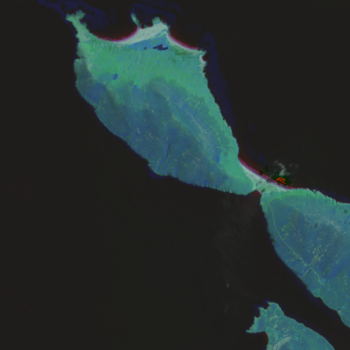

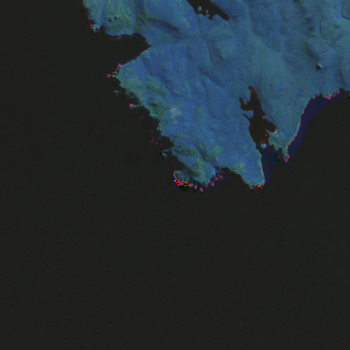

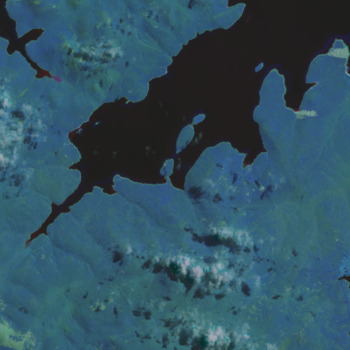

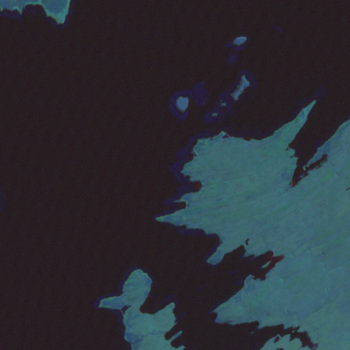

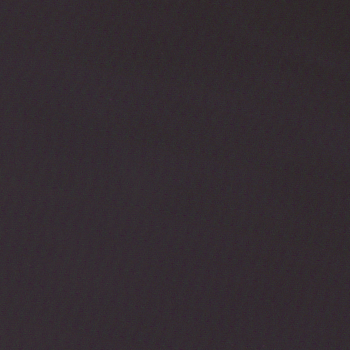

In [135]:
for i in range(5):
    display(train_ds[i]['pixel_values'])

## Image processor & data augmentation

In [136]:
from torchvision.transforms import ColorJitter, RandomAffine, InterpolationMode, RandomHorizontalFlip, RandomVerticalFlip, Compose
from transformers import (
    SegformerImageProcessor,
)
import torch

processor = SegformerImageProcessor()

def train_transforms(example_batch):
    state = torch.get_rng_state()
    transform_fn = Compose([
        RandomAffine(degrees=90,translate=(0.3,0.3),scale=(0.7,1.3),interpolation=InterpolationMode.BILINEAR ),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5)
    ])
    images = [transform_fn(x) for x in example_batch['pixel_values']]
    torch.set_rng_state(state)
    transform_fn = Compose([
        RandomAffine(degrees=90,translate=(0.3,0.3),scale=(0.7,1.3),interpolation=InterpolationMode.BILINEAR ),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5)
    ])
    labels = [transform_fn(x) for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [137]:
from PIL import Image

# 3. Fine-tune


In [138]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

id2label = {
    0: 'background',
    1: 'kelp'
}

label2id = {
    'background': 0,
    'kelp': 1,
}
pretrained_model_name = "nvidia/mit-b1"

model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id,
    semantic_loss_ignore_index=255,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set up the Trainer

In [139]:
from transformers import TrainingArguments

epochs = 40
lr = 0.00006
batch_size = 8

hub_model_id = "segformer-b1-kelp-rgb-agg-imgaug-jan-25"

training_args = TrainingArguments(
    "segformer-b1-kelp-rgb-agg-imgaug-jan-25",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=30,
    eval_steps=30,
    report_to='wandb',
    metric_for_best_model='eval_iou_kelp',
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    warmup_ratio=0.2,
    weight_decay=0.1,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [140]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    print("Pred labels 0 sum: ",(pred_labels==0).sum())
    print("Pred labels nonzero sum: ",(pred_labels!=0).sum())
    print("labels 0 sum: ",(labels==0).sum())
    print("labels nonzero sum: ",(labels!=0).sum())
    metrics = metric._compute(
          predictions=pred_labels,
          references=labels,
          num_labels=len(id2label),
          ignore_index=255,
      )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()
    print(per_category_accuracy)
    print(per_category_iou)

    metrics.update({"eval_accuracy_kelp": per_category_accuracy[1]})
    metrics.update({"eval_iou_kelp": per_category_iou[1]})
    metrics.update({"eval_accuracy_bg": per_category_accuracy[0]})
    metrics.update({"eval_iou_bg": per_category_iou[0]})
    return metrics

In [141]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [142]:
hf_dataset_identifier = 'samitizerxu/kelp_data'

In [143]:
trainer.train()

  0%|          | 0/19720 [00:00<?, ?it/s]

{'loss': 0.6898, 'learning_rate': 1.5212981744421906e-08, 'epoch': 0.0}
{'loss': 0.6922, 'learning_rate': 3.042596348884381e-08, 'epoch': 0.0}
{'loss': 0.6927, 'learning_rate': 4.563894523326572e-08, 'epoch': 0.01}
{'loss': 0.6981, 'learning_rate': 6.085192697768762e-08, 'epoch': 0.01}
{'loss': 0.6922, 'learning_rate': 7.606490872210953e-08, 'epoch': 0.01}
{'loss': 0.7048, 'learning_rate': 9.127789046653144e-08, 'epoch': 0.01}
{'loss': 0.6992, 'learning_rate': 1.0649087221095335e-07, 'epoch': 0.01}
{'loss': 0.6917, 'learning_rate': 1.2170385395537525e-07, 'epoch': 0.02}
{'loss': 0.6941, 'learning_rate': 1.3691683569979717e-07, 'epoch': 0.02}
{'loss': 0.6991, 'learning_rate': 1.5212981744421907e-07, 'epoch': 0.02}
{'loss': 0.6925, 'learning_rate': 1.6734279918864096e-07, 'epoch': 0.02}
{'loss': 0.6911, 'learning_rate': 1.825557809330629e-07, 'epoch': 0.02}
{'loss': 0.6933, 'learning_rate': 1.9776876267748478e-07, 'epoch': 0.03}
{'loss': 0.6941, 'learning_rate': 2.129817444219067e-07, 'e

  0%|          | 0/212 [00:00<?, ?it/s]

Pred labels 0 sum:  107782497
Pred labels nonzero sum:  335503007
labels 0 sum:  440309002
labels nonzero sum:  2976502


Checkpoint destination directory segformer-b1-kelp-rgb-agg-imgaug-jan-22/checkpoint-30 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[0.24296190746515783, 0.7298231279535509]
[0.2425189699158935, 0.006459332631155857]
{'eval_accuracy_kelp': 0.7298231279535509, 'eval_iou_kelp': 0.006459332631155857, 'eval_accuracy_bg': 0.24296190746515783, 'eval_iou_bg': 0.2425189699158935, 'eval_loss': 0.7189300656318665, 'eval_mean_iou': 0.12448915127352468, 'eval_mean_accuracy': 0.4863925177093543, 'eval_overall_accuracy': 0.24623100465744083, 'eval_runtime': 149.9904, 'eval_samples_per_second': 11.274, 'eval_steps_per_second': 1.413, 'epoch': 0.06}
{'loss': 0.6895, 'learning_rate': 4.716024340770791e-07, 'epoch': 0.06}
{'loss': 0.6955, 'learning_rate': 4.86815415821501e-07, 'epoch': 0.06}
{'loss': 0.6894, 'learning_rate': 5.020283975659229e-07, 'epoch': 0.07}
{'loss': 0.6941, 'learning_rate': 5.172413793103448e-07, 'epoch': 0.07}
{'loss': 0.6885, 'learning_rate': 5.324543610547667e-07, 'epoch': 0.07}
{'loss': 0.7002, 'learning_rate': 5.476673427991887e-07, 'epoch': 0.07}
{'loss': 0.6985, 'learning_rate': 5.628803245436105e-07, 'e

  0%|          | 0/212 [00:00<?, ?it/s]

Pred labels 0 sum:  128766356
Pred labels nonzero sum:  314519148
labels 0 sum:  440309002
labels nonzero sum:  2976502


Checkpoint destination directory segformer-b1-kelp-rgb-agg-imgaug-jan-22/checkpoint-60 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[0.2904016529736996, 0.6976672617723758]
[0.28980934690854465, 0.0065836481742912656]
{'eval_accuracy_kelp': 0.6976672617723758, 'eval_iou_kelp': 0.0065836481742912656, 'eval_accuracy_bg': 0.2904016529736996, 'eval_iou_bg': 0.28980934690854465, 'eval_loss': 0.7411625981330872, 'eval_mean_iou': 0.14819649754141795, 'eval_mean_accuracy': 0.4940344573730377, 'eval_overall_accuracy': 0.2931362943914358, 'eval_runtime': 89.8715, 'eval_samples_per_second': 18.816, 'eval_steps_per_second': 2.359, 'epoch': 0.12}
{'loss': 0.6918, 'learning_rate': 9.279918864097364e-07, 'epoch': 0.12}
{'loss': 0.6812, 'learning_rate': 9.432048681541582e-07, 'epoch': 0.13}
{'loss': 0.6865, 'learning_rate': 9.584178498985803e-07, 'epoch': 0.13}
{'loss': 0.6882, 'learning_rate': 9.73630831643002e-07, 'epoch': 0.13}
{'loss': 0.6845, 'learning_rate': 9.888438133874242e-07, 'epoch': 0.13}
{'loss': 0.6889, 'learning_rate': 1.0040567951318459e-06, 'epoch': 0.13}
{'loss': 0.6894, 'learning_rate': 1.0192697768762678e-06, 

  0%|          | 0/212 [00:00<?, ?it/s]

Pred labels 0 sum:  150069228
Pred labels nonzero sum:  293216276
labels 0 sum:  440309002
labels nonzero sum:  2976502


Checkpoint destination directory segformer-b1-kelp-rgb-agg-imgaug-jan-22/checkpoint-90 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[0.3387957509894381, 0.6995100288862565]
[0.3381089431332615, 0.007079283773726208]
{'eval_accuracy_kelp': 0.6995100288862565, 'eval_iou_kelp': 0.007079283773726208, 'eval_accuracy_bg': 0.3387957509894381, 'eval_iou_bg': 0.3381089431332615, 'eval_loss': 0.7388788461685181, 'eval_mean_iou': 0.17259411345349385, 'eval_mean_accuracy': 0.5191528899378473, 'eval_overall_accuracy': 0.34121781703919646, 'eval_runtime': 86.7295, 'eval_samples_per_second': 19.497, 'eval_steps_per_second': 2.444, 'epoch': 0.18}
{'loss': 0.676, 'learning_rate': 1.3843813387423936e-06, 'epoch': 0.18}
{'loss': 0.6811, 'learning_rate': 1.3995943204868155e-06, 'epoch': 0.19}
{'loss': 0.6756, 'learning_rate': 1.4148073022312375e-06, 'epoch': 0.19}
{'loss': 0.6812, 'learning_rate': 1.4300202839756592e-06, 'epoch': 0.19}
{'loss': 0.6764, 'learning_rate': 1.4452332657200814e-06, 'epoch': 0.19}
{'loss': 0.6792, 'learning_rate': 1.460446247464503e-06, 'epoch': 0.19}
{'loss': 0.6748, 'learning_rate': 1.475659229208925e-06, 

  0%|          | 0/212 [00:00<?, ?it/s]

Pred labels 0 sum:  201651618
Pred labels nonzero sum:  241633886
labels 0 sum:  440309002
labels nonzero sum:  2976502


Checkpoint destination directory segformer-b1-kelp-rgb-agg-imgaug-jan-22/checkpoint-120 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[0.45577934379819923, 0.6748297162239434]
[0.45477966495375266, 0.008279544357461288]
{'eval_accuracy_kelp': 0.6748297162239434, 'eval_iou_kelp': 0.008279544357461288, 'eval_accuracy_bg': 0.45577934379819923, 'eval_iou_bg': 0.45477966495375266, 'eval_loss': 0.7178513407707214, 'eval_mean_iou': 0.23152960465560699, 'eval_mean_accuracy': 0.5653045300110713, 'eval_overall_accuracy': 0.45725018790598665, 'eval_runtime': 86.3924, 'eval_samples_per_second': 19.573, 'eval_steps_per_second': 2.454, 'epoch': 0.24}
{'loss': 0.6617, 'learning_rate': 1.8407707910750508e-06, 'epoch': 0.25}
{'loss': 0.667, 'learning_rate': 1.8559837728194727e-06, 'epoch': 0.25}
{'loss': 0.6654, 'learning_rate': 1.8711967545638947e-06, 'epoch': 0.25}
{'loss': 0.6708, 'learning_rate': 1.8864097363083164e-06, 'epoch': 0.25}
{'loss': 0.6628, 'learning_rate': 1.9016227180527386e-06, 'epoch': 0.25}
{'loss': 0.6629, 'learning_rate': 1.9168356997971605e-06, 'epoch': 0.26}
{'loss': 0.6584, 'learning_rate': 1.932048681541582e

  0%|          | 0/212 [00:00<?, ?it/s]

Pred labels 0 sum:  212630281
Pred labels nonzero sum:  230655223
labels 0 sum:  440309002
labels nonzero sum:  2976502
[0.48089321371630733, 0.7014381310679448]
[0.47992458808803506, 0.009017003095823392]
{'eval_accuracy_kelp': 0.7014381310679448, 'eval_iou_kelp': 0.009017003095823392, 'eval_accuracy_bg': 0.48089321371630733, 'eval_iou_bg': 0.47992458808803506, 'eval_loss': 0.7134412527084351, 'eval_mean_iou': 0.24447079559192922, 'eval_mean_accuracy': 0.5911656723921261, 'eval_overall_accuracy': 0.482374093153292, 'eval_runtime': 86.8529, 'eval_samples_per_second': 19.47, 'eval_steps_per_second': 2.441, 'epoch': 0.3}
{'loss': 0.6477, 'learning_rate': 2.297160243407708e-06, 'epoch': 0.31}
{'loss': 0.6451, 'learning_rate': 2.31237322515213e-06, 'epoch': 0.31}
{'loss': 0.6475, 'learning_rate': 2.327586206896552e-06, 'epoch': 0.31}
{'loss': 0.6476, 'learning_rate': 2.342799188640974e-06, 'epoch': 0.31}
{'loss': 0.6505, 'learning_rate': 2.3580121703853953e-06, 'epoch': 0.31}
{'loss': 0.65

  0%|          | 0/212 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

processor.push_to_hub(hub_model_id) 
trainer.push_to_hub(**kwargs)  

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/samitizerxu/segformer-b1-kelp-rgb-agg-imgaug-jan-22/commit/e08b2cd0af56946aee1d1216421217cd9861493c', commit_message='End of training', commit_description='', oid='e08b2cd0af56946aee1d1216421217cd9861493c', pr_url=None, pr_revision=None, pr_num=None)

# 4. Inference

## Use the model from the hub

In [44]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

processor = SegformerImageProcessor()
model = SegformerForSemanticSegmentation.from_pretrained(f"samitizerxu/{hub_model_id}")

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [45]:
#@title `def sidewalk_palette()`

def my_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
    ]

In [46]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(my_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

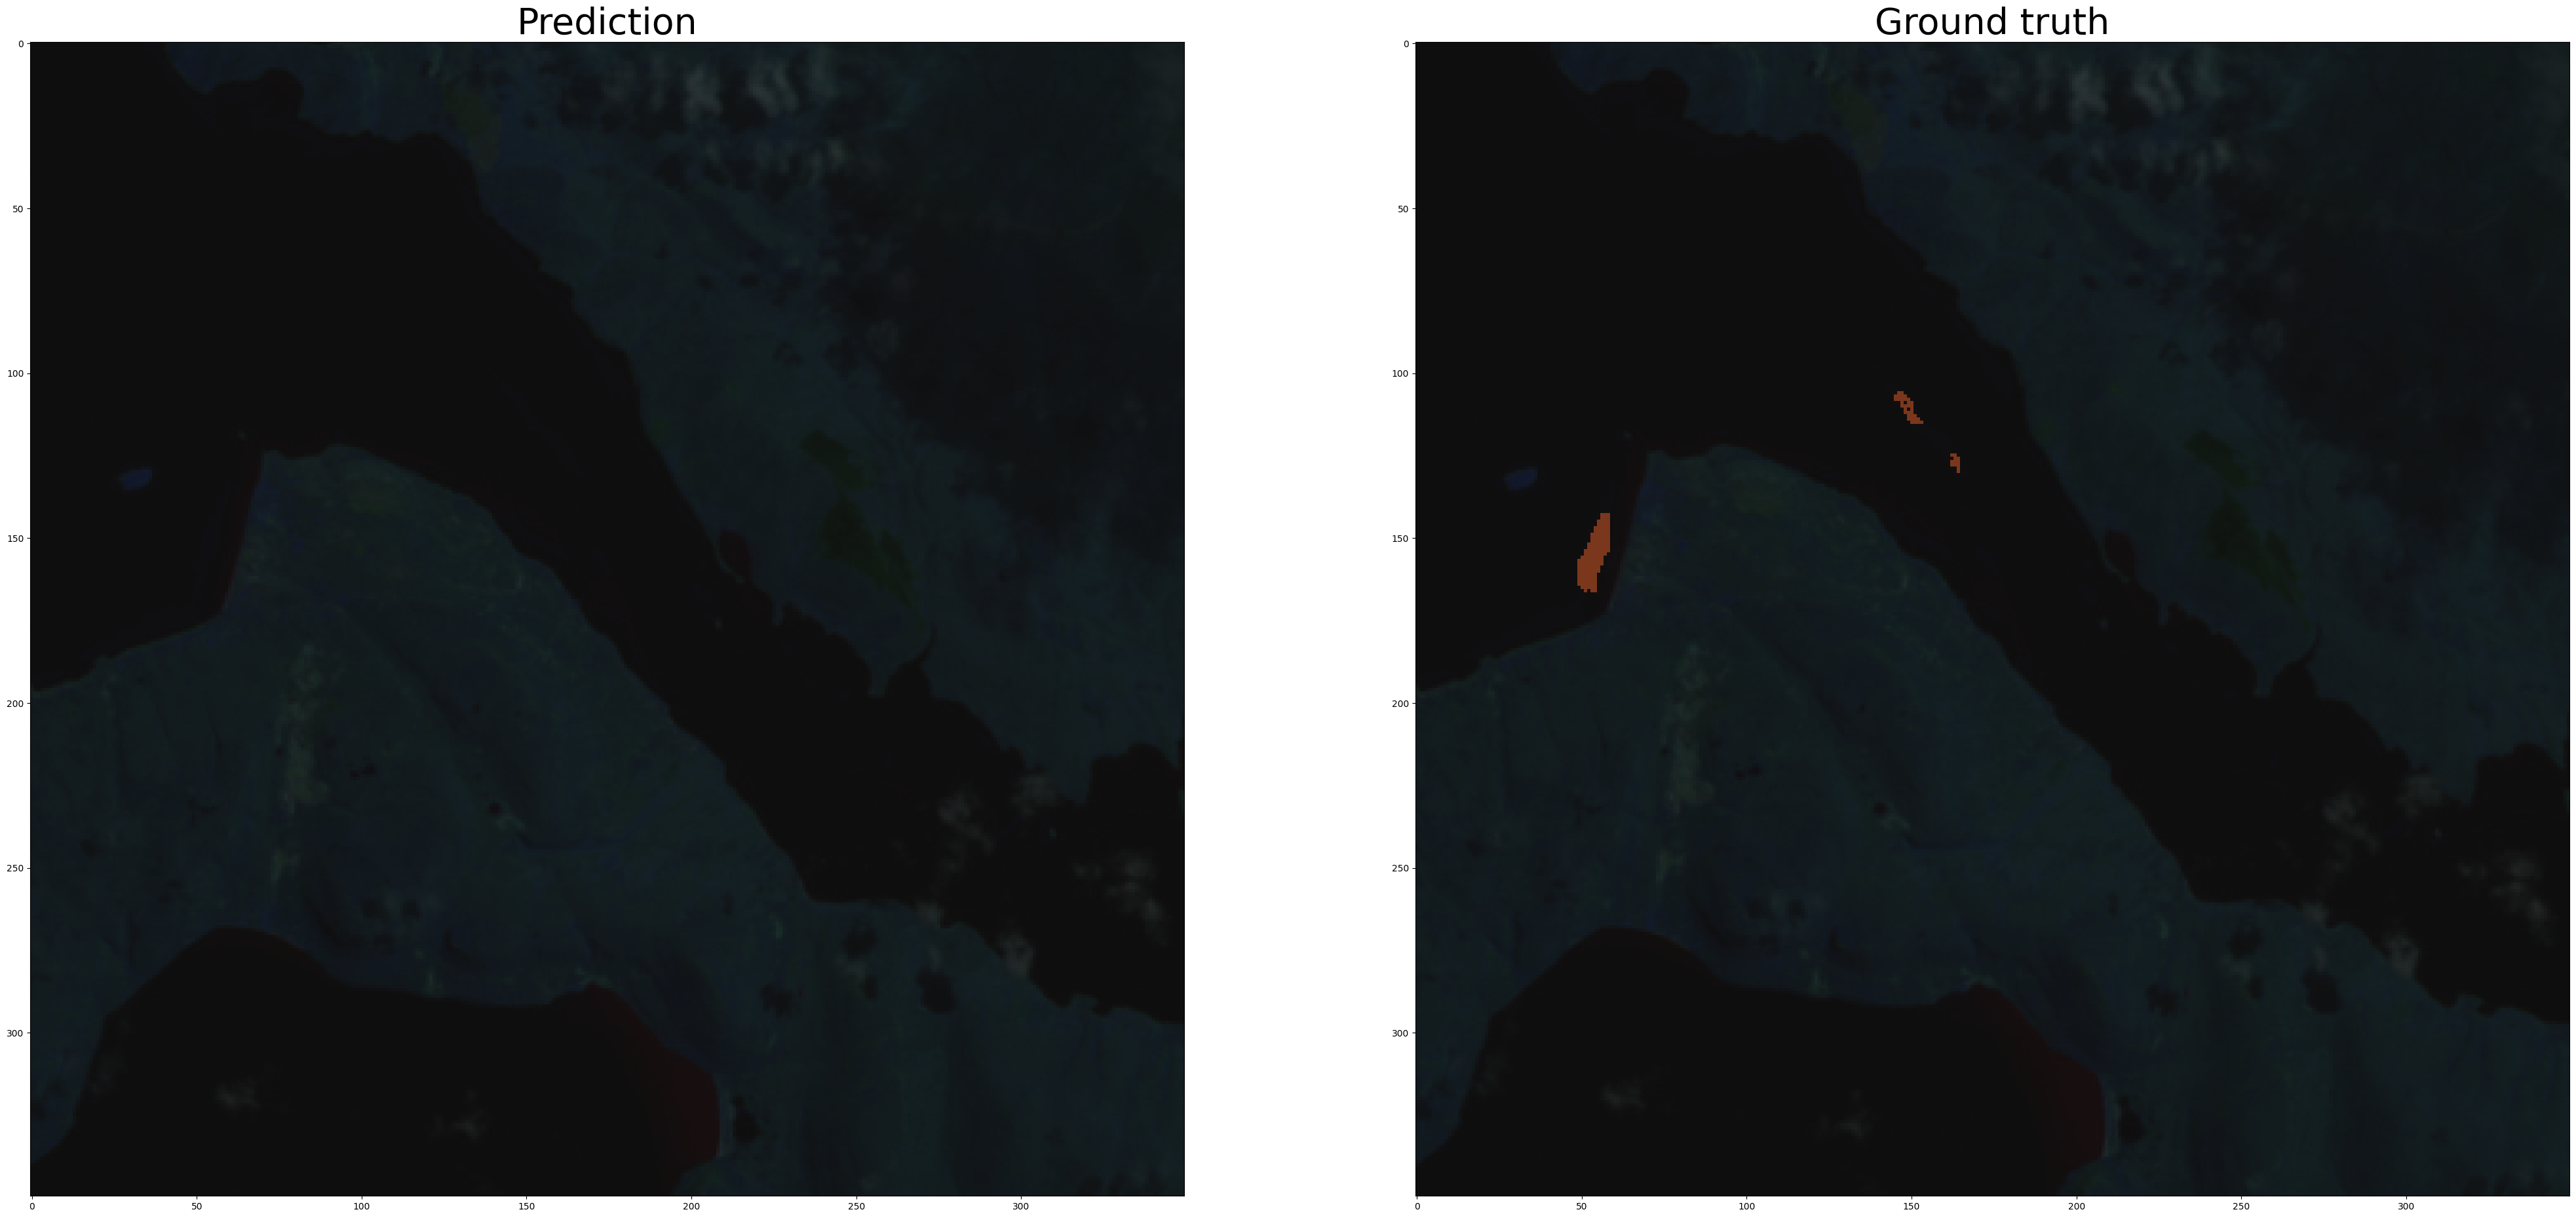

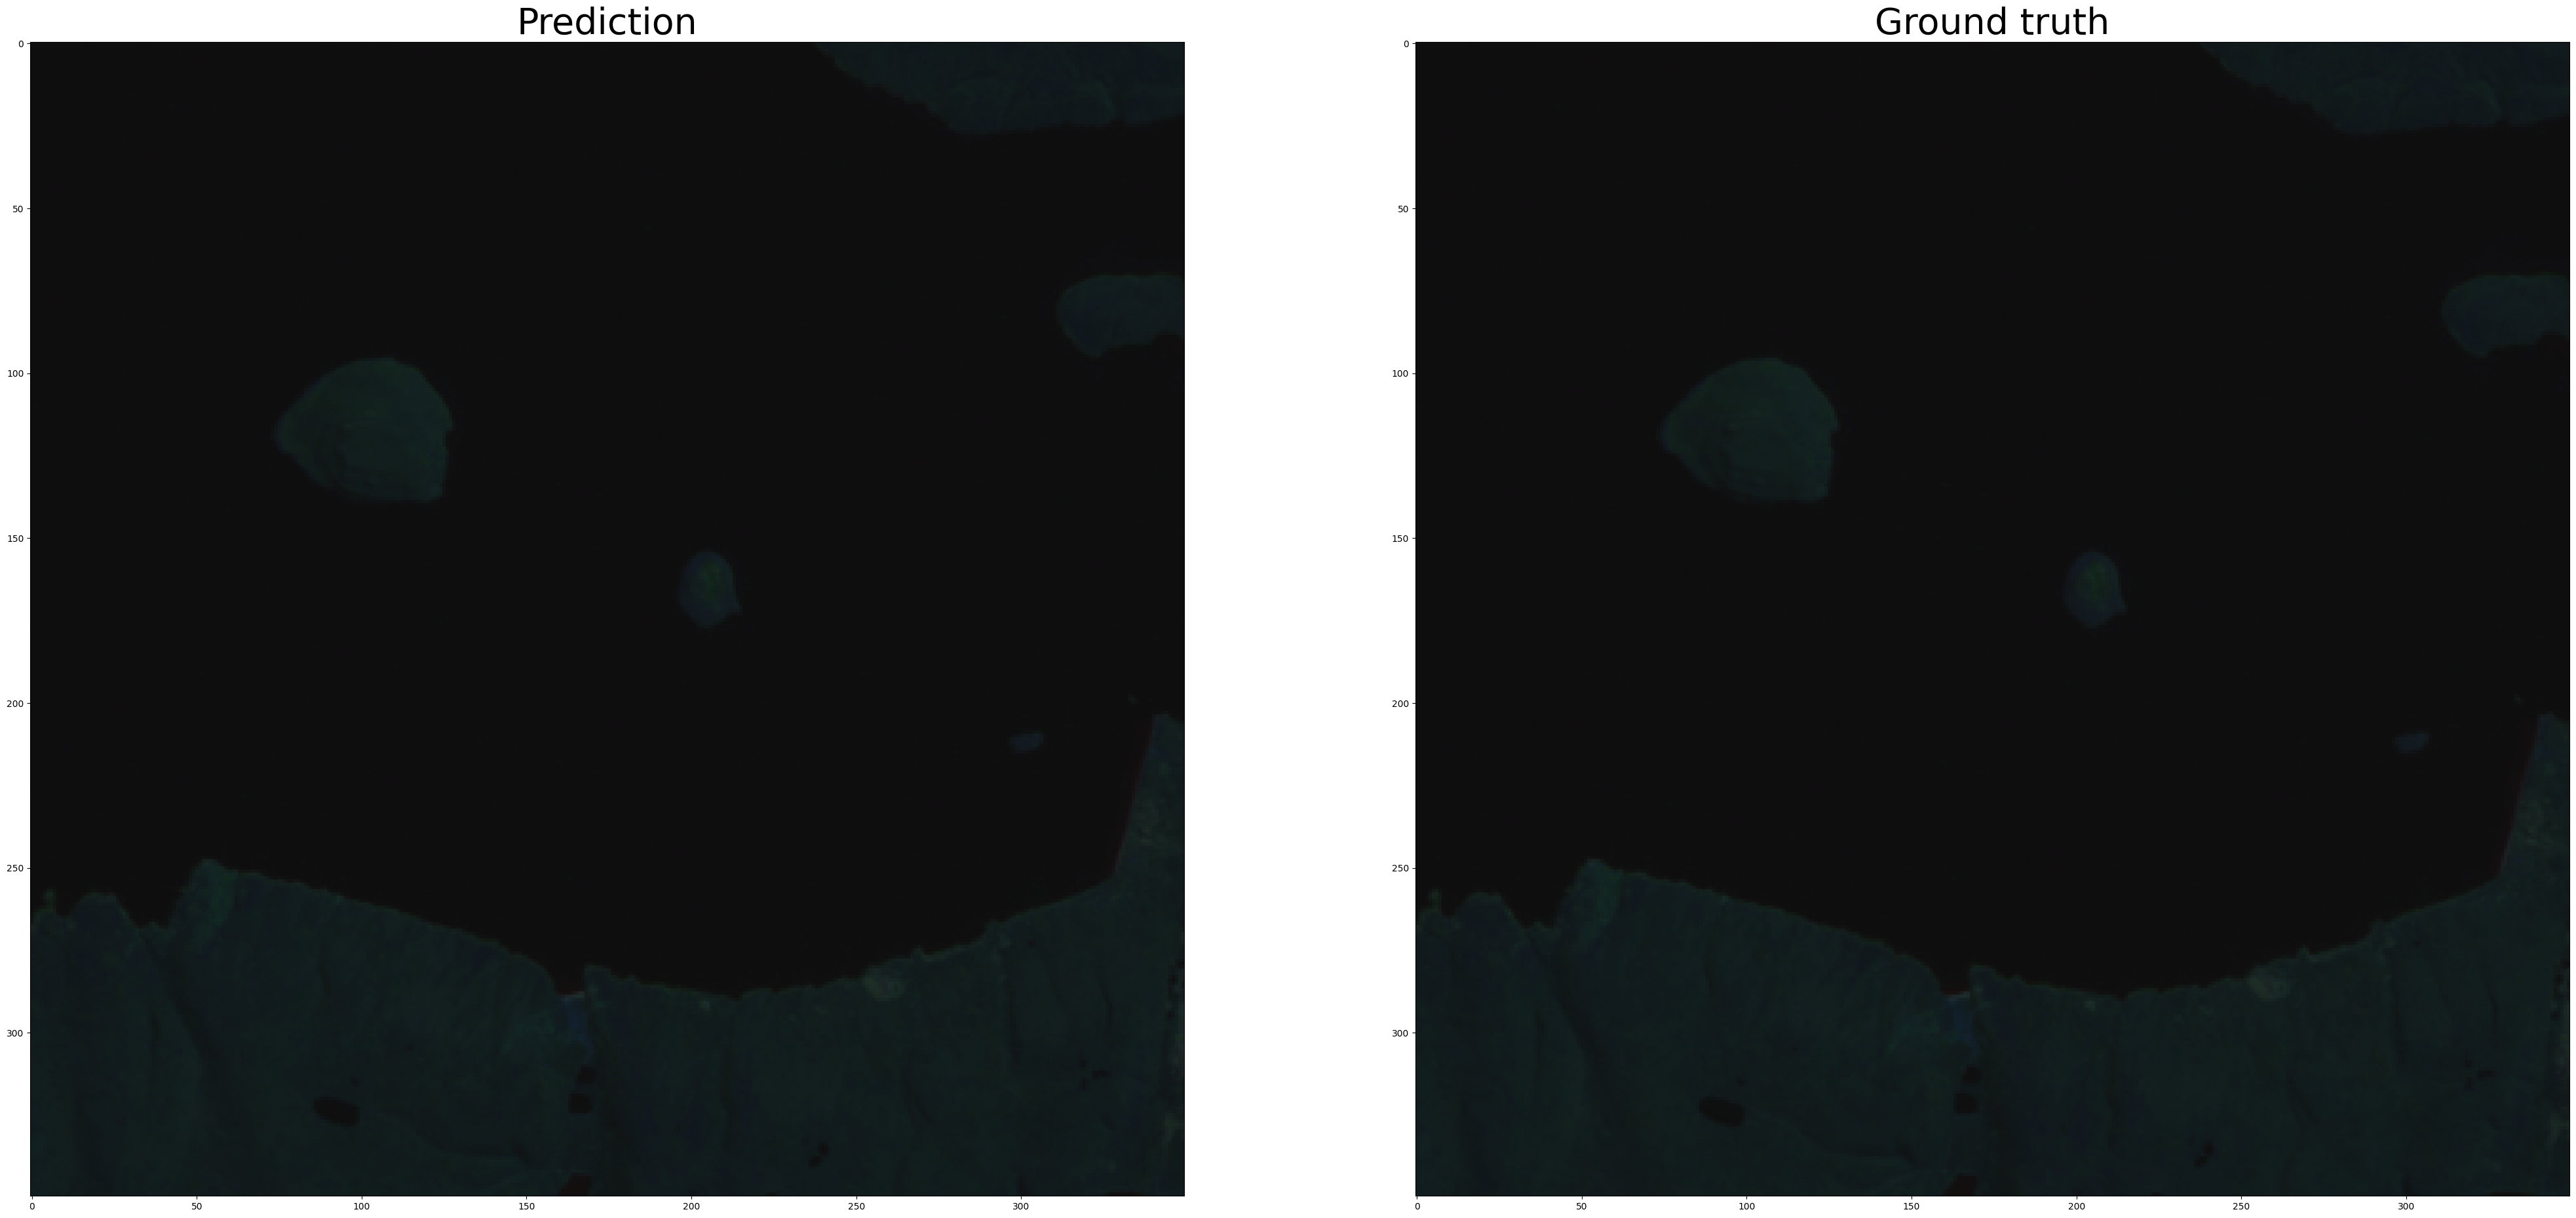

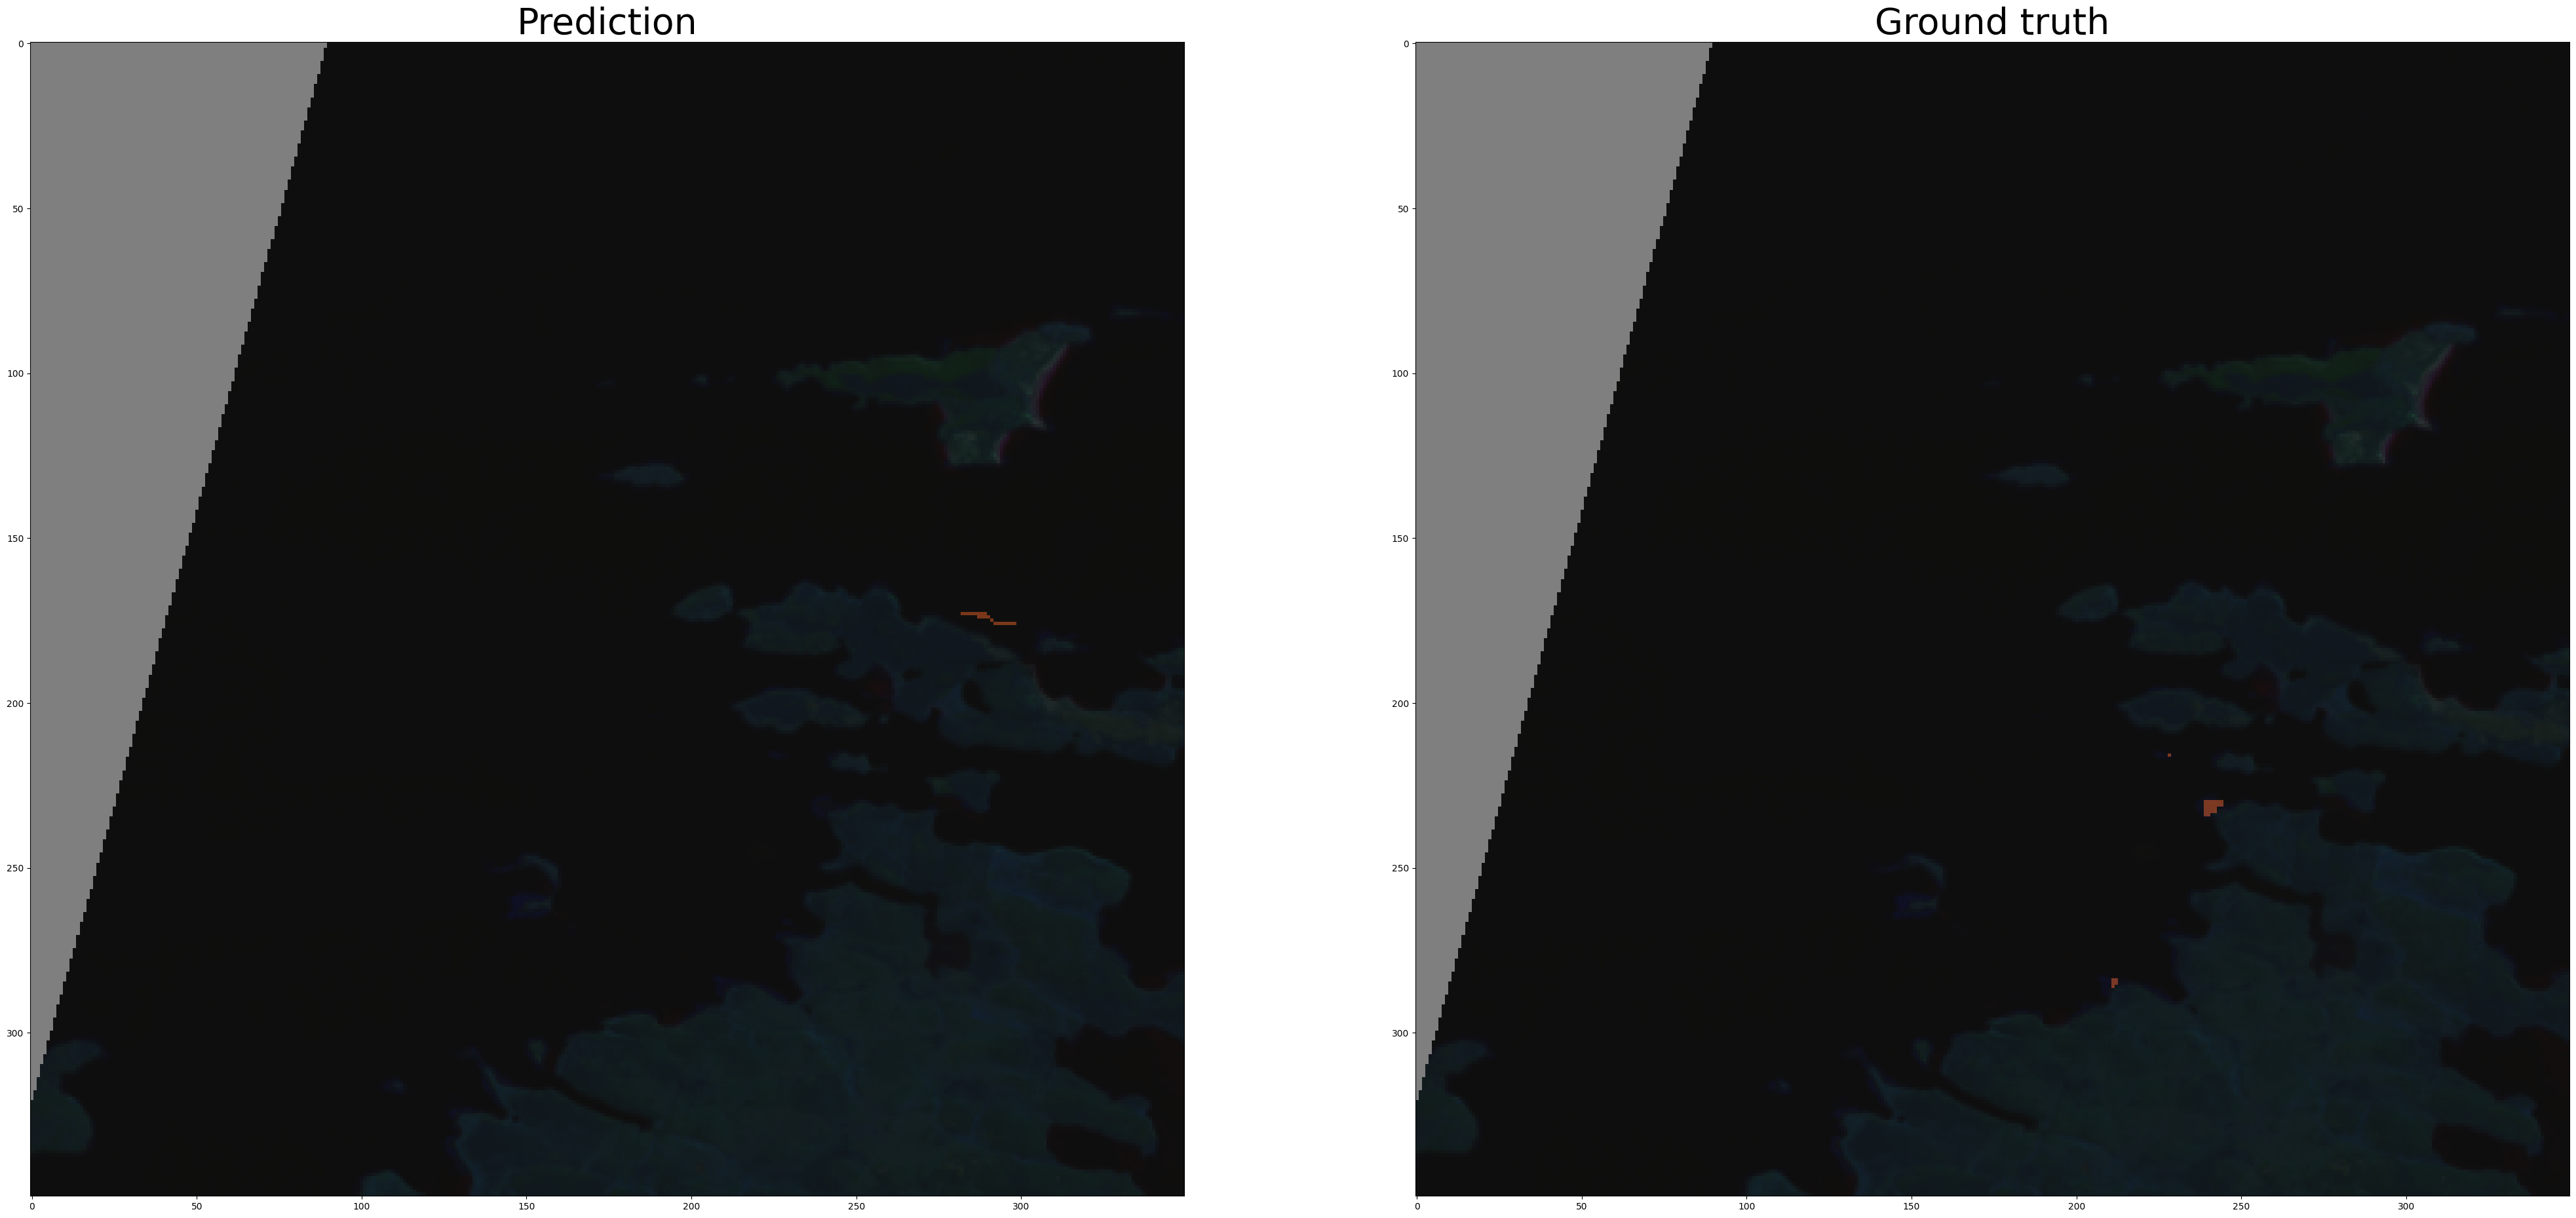

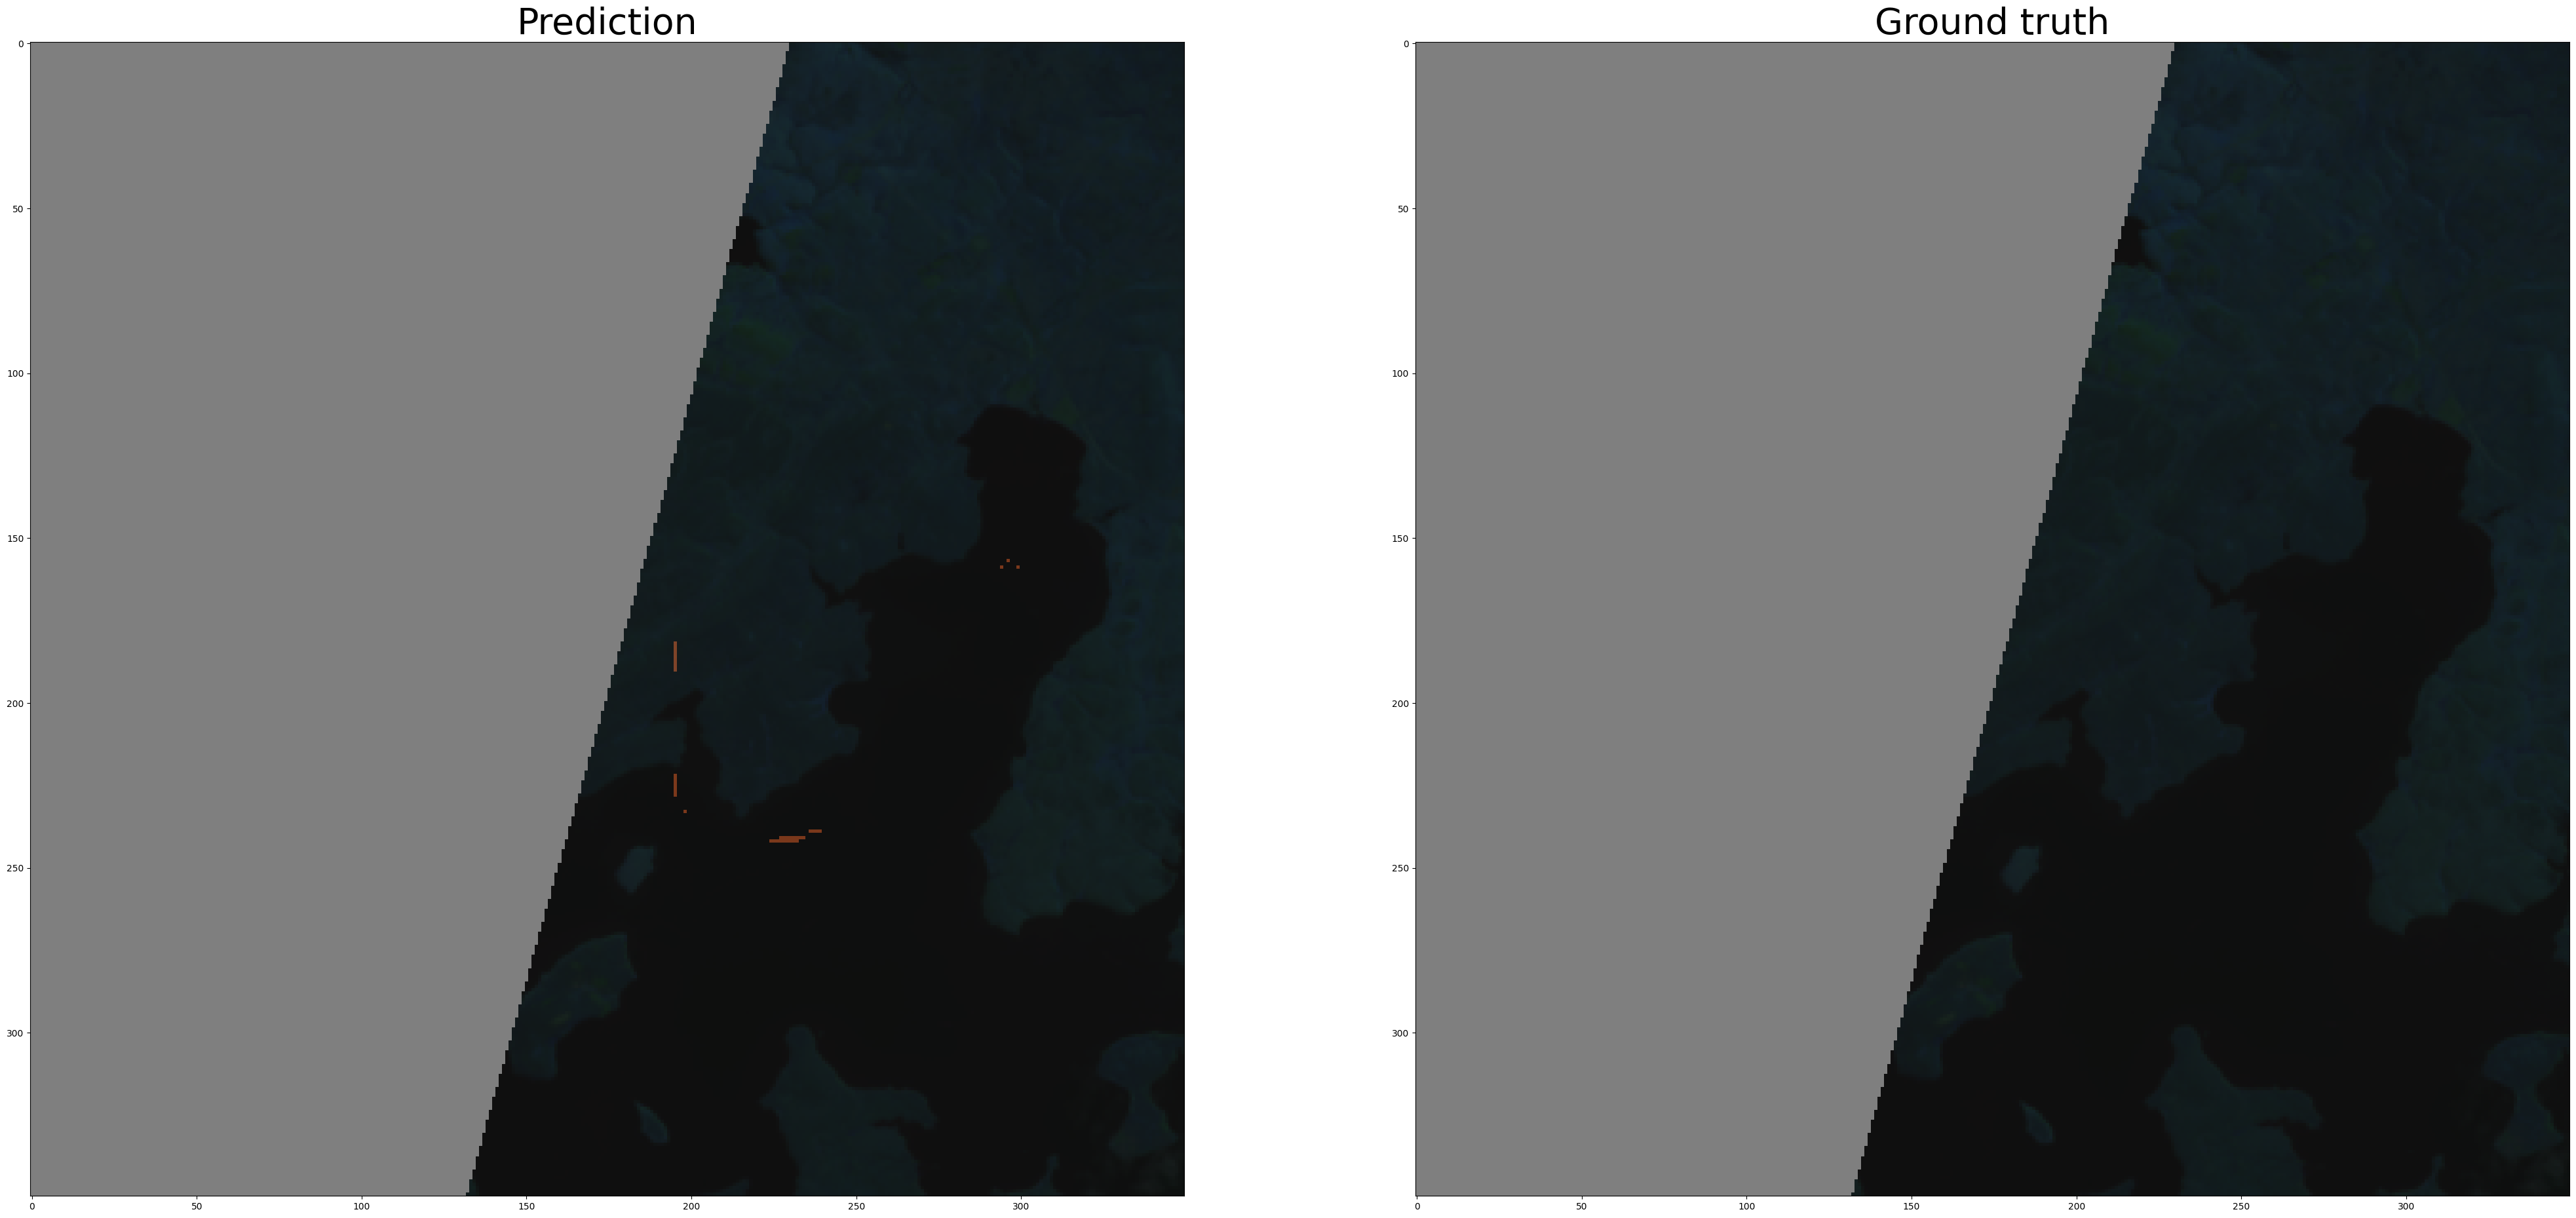

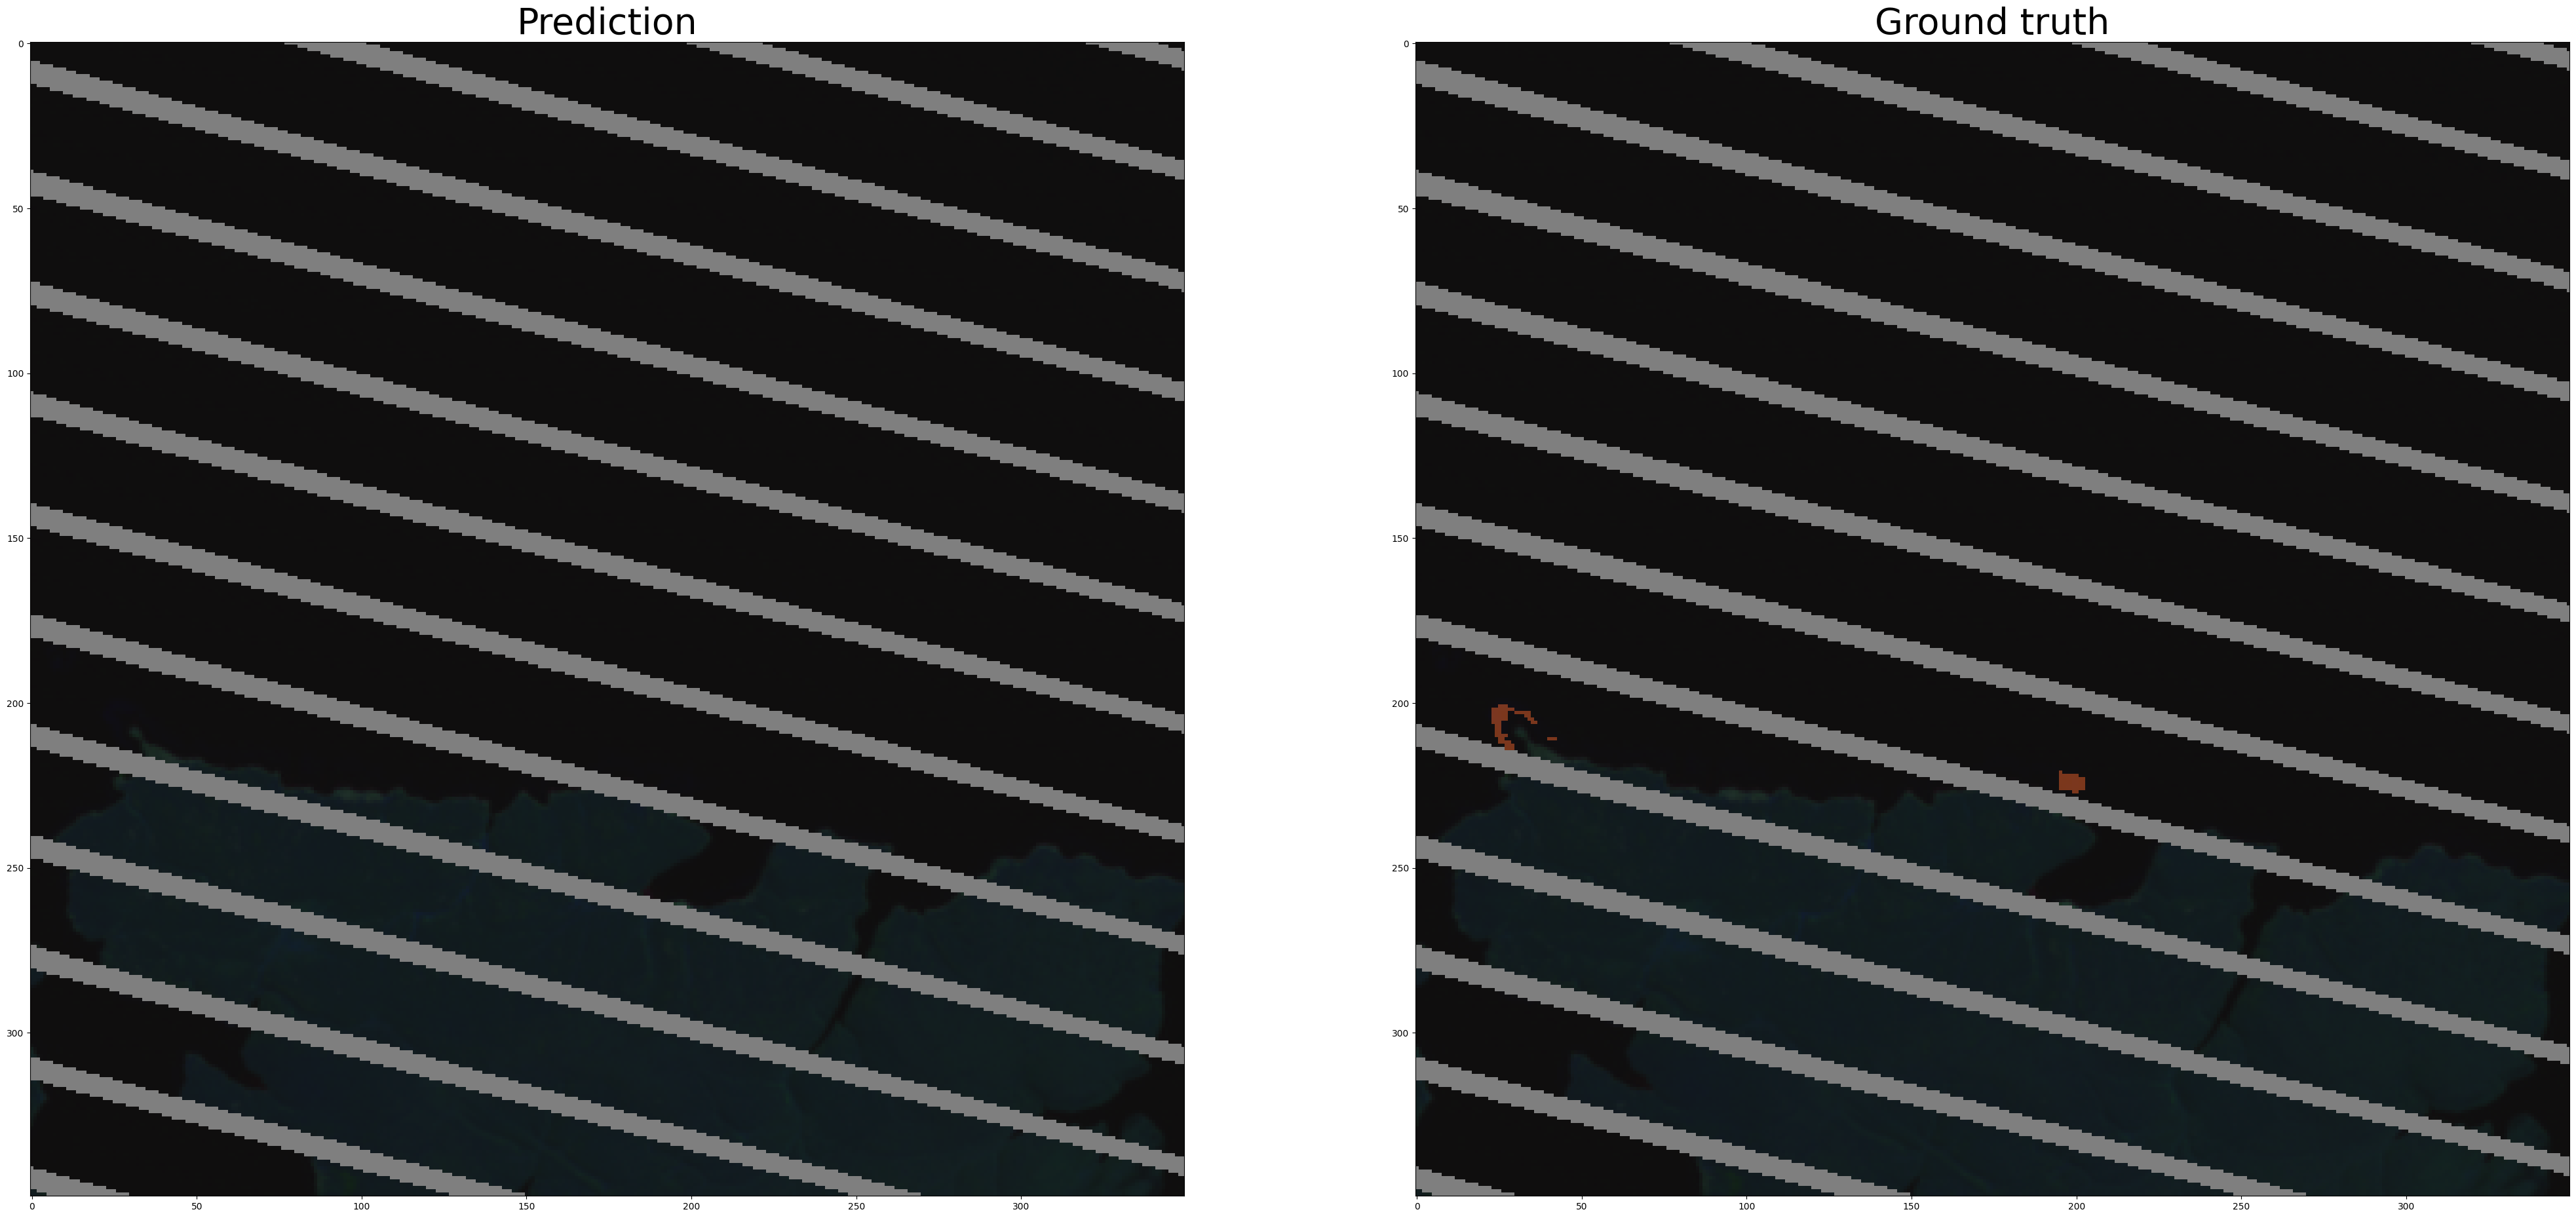

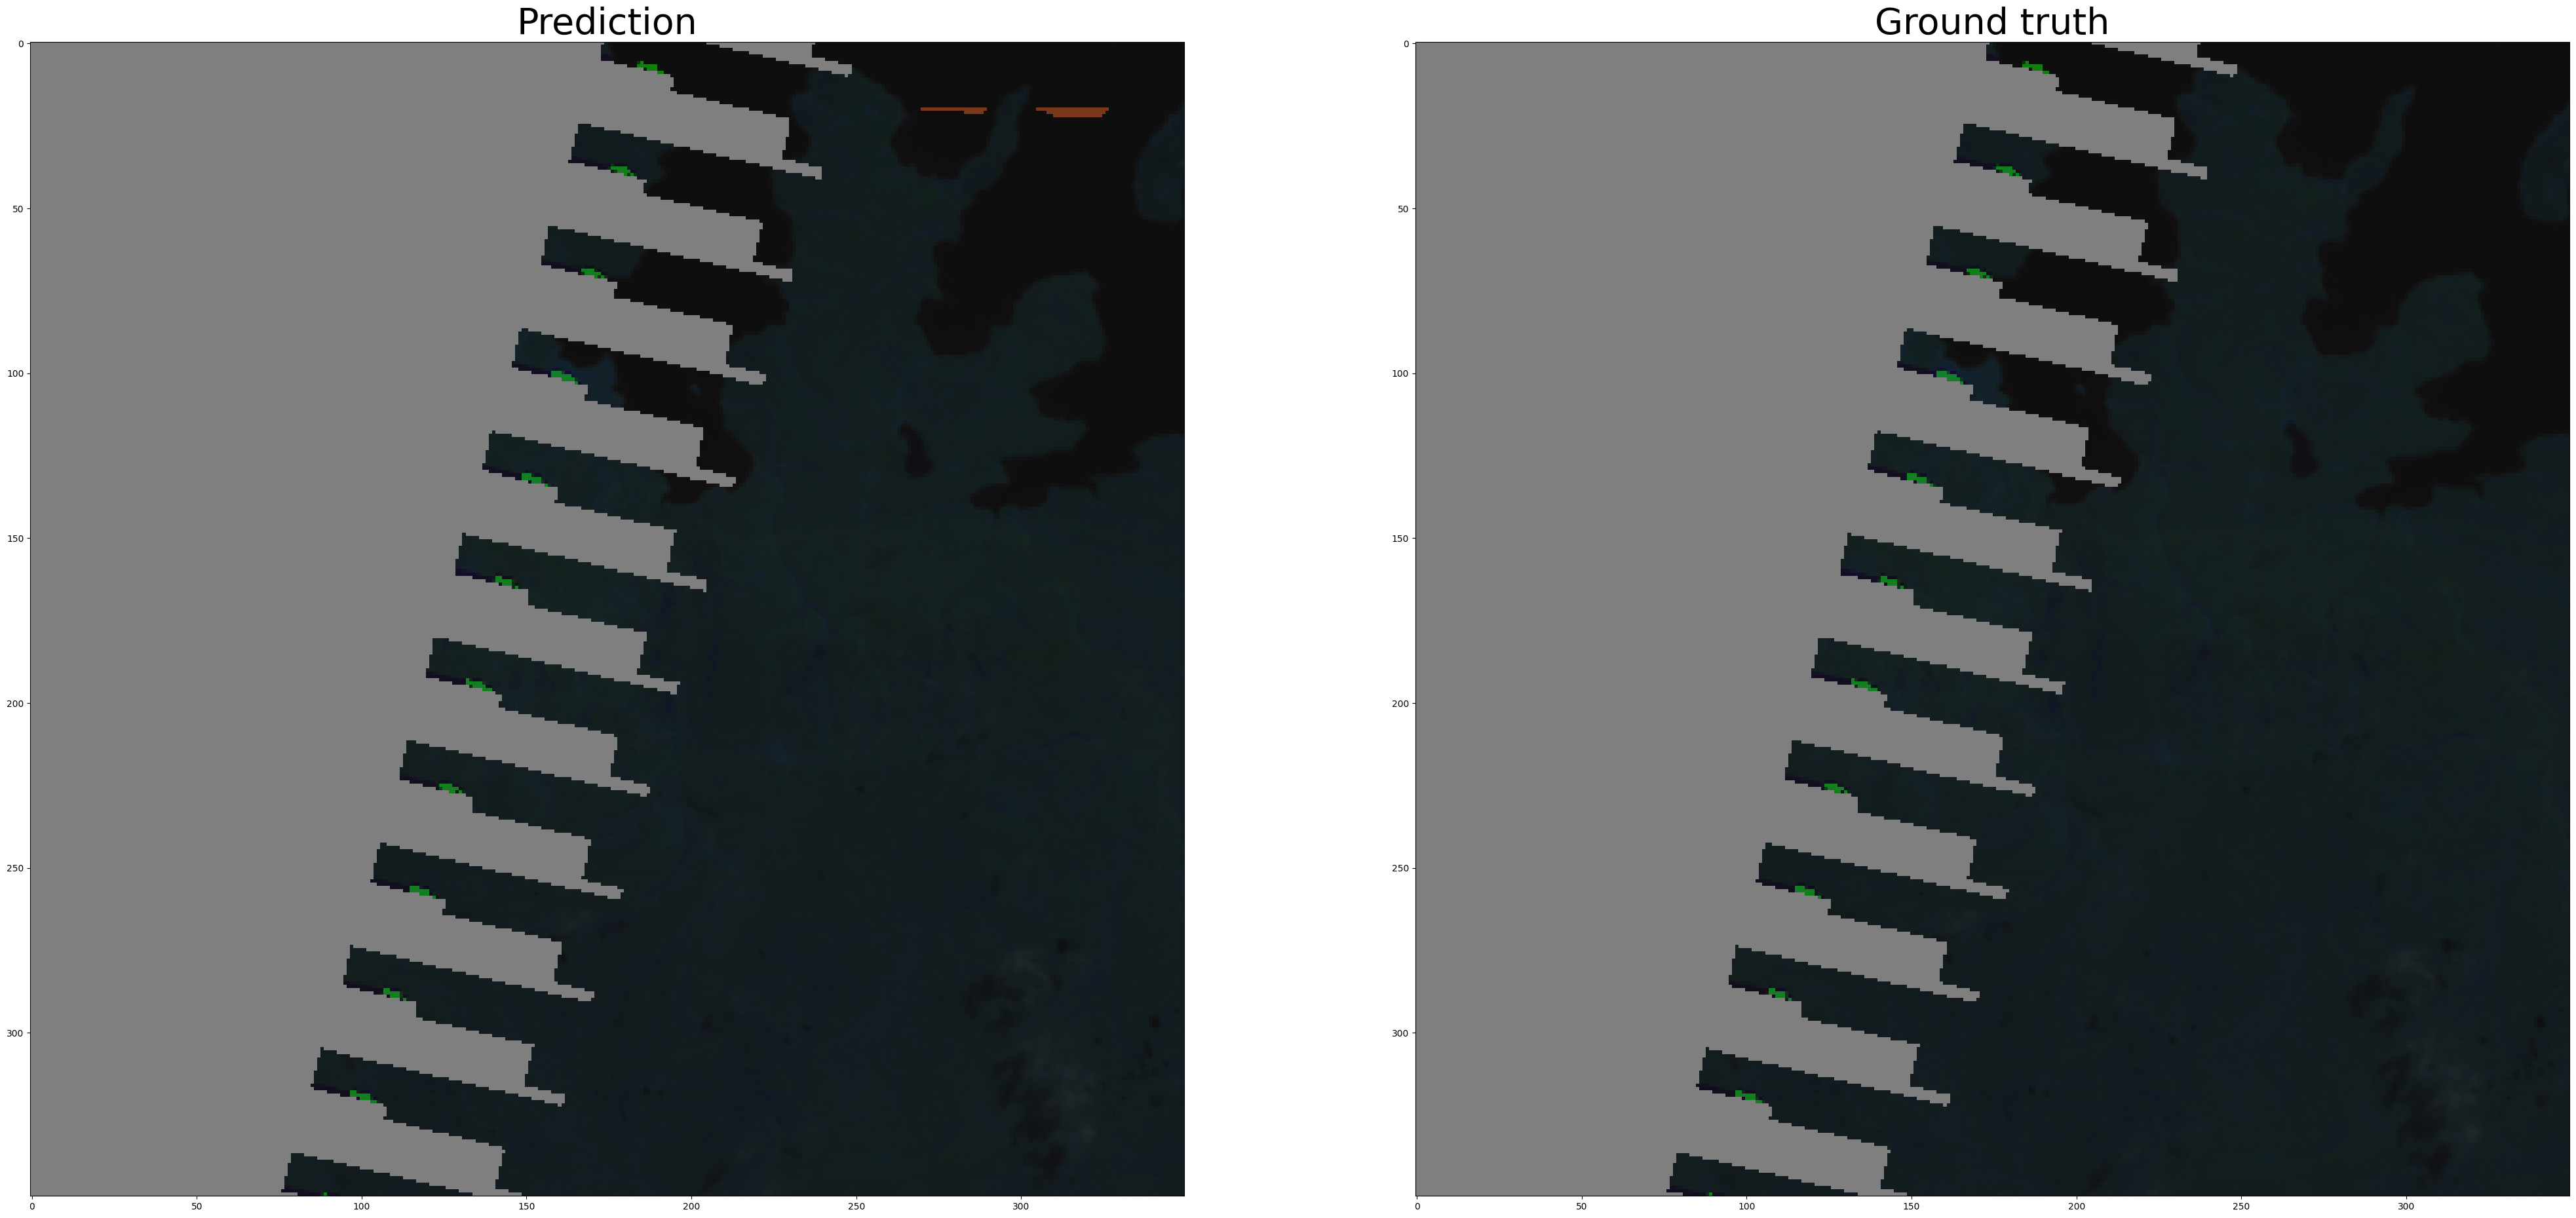

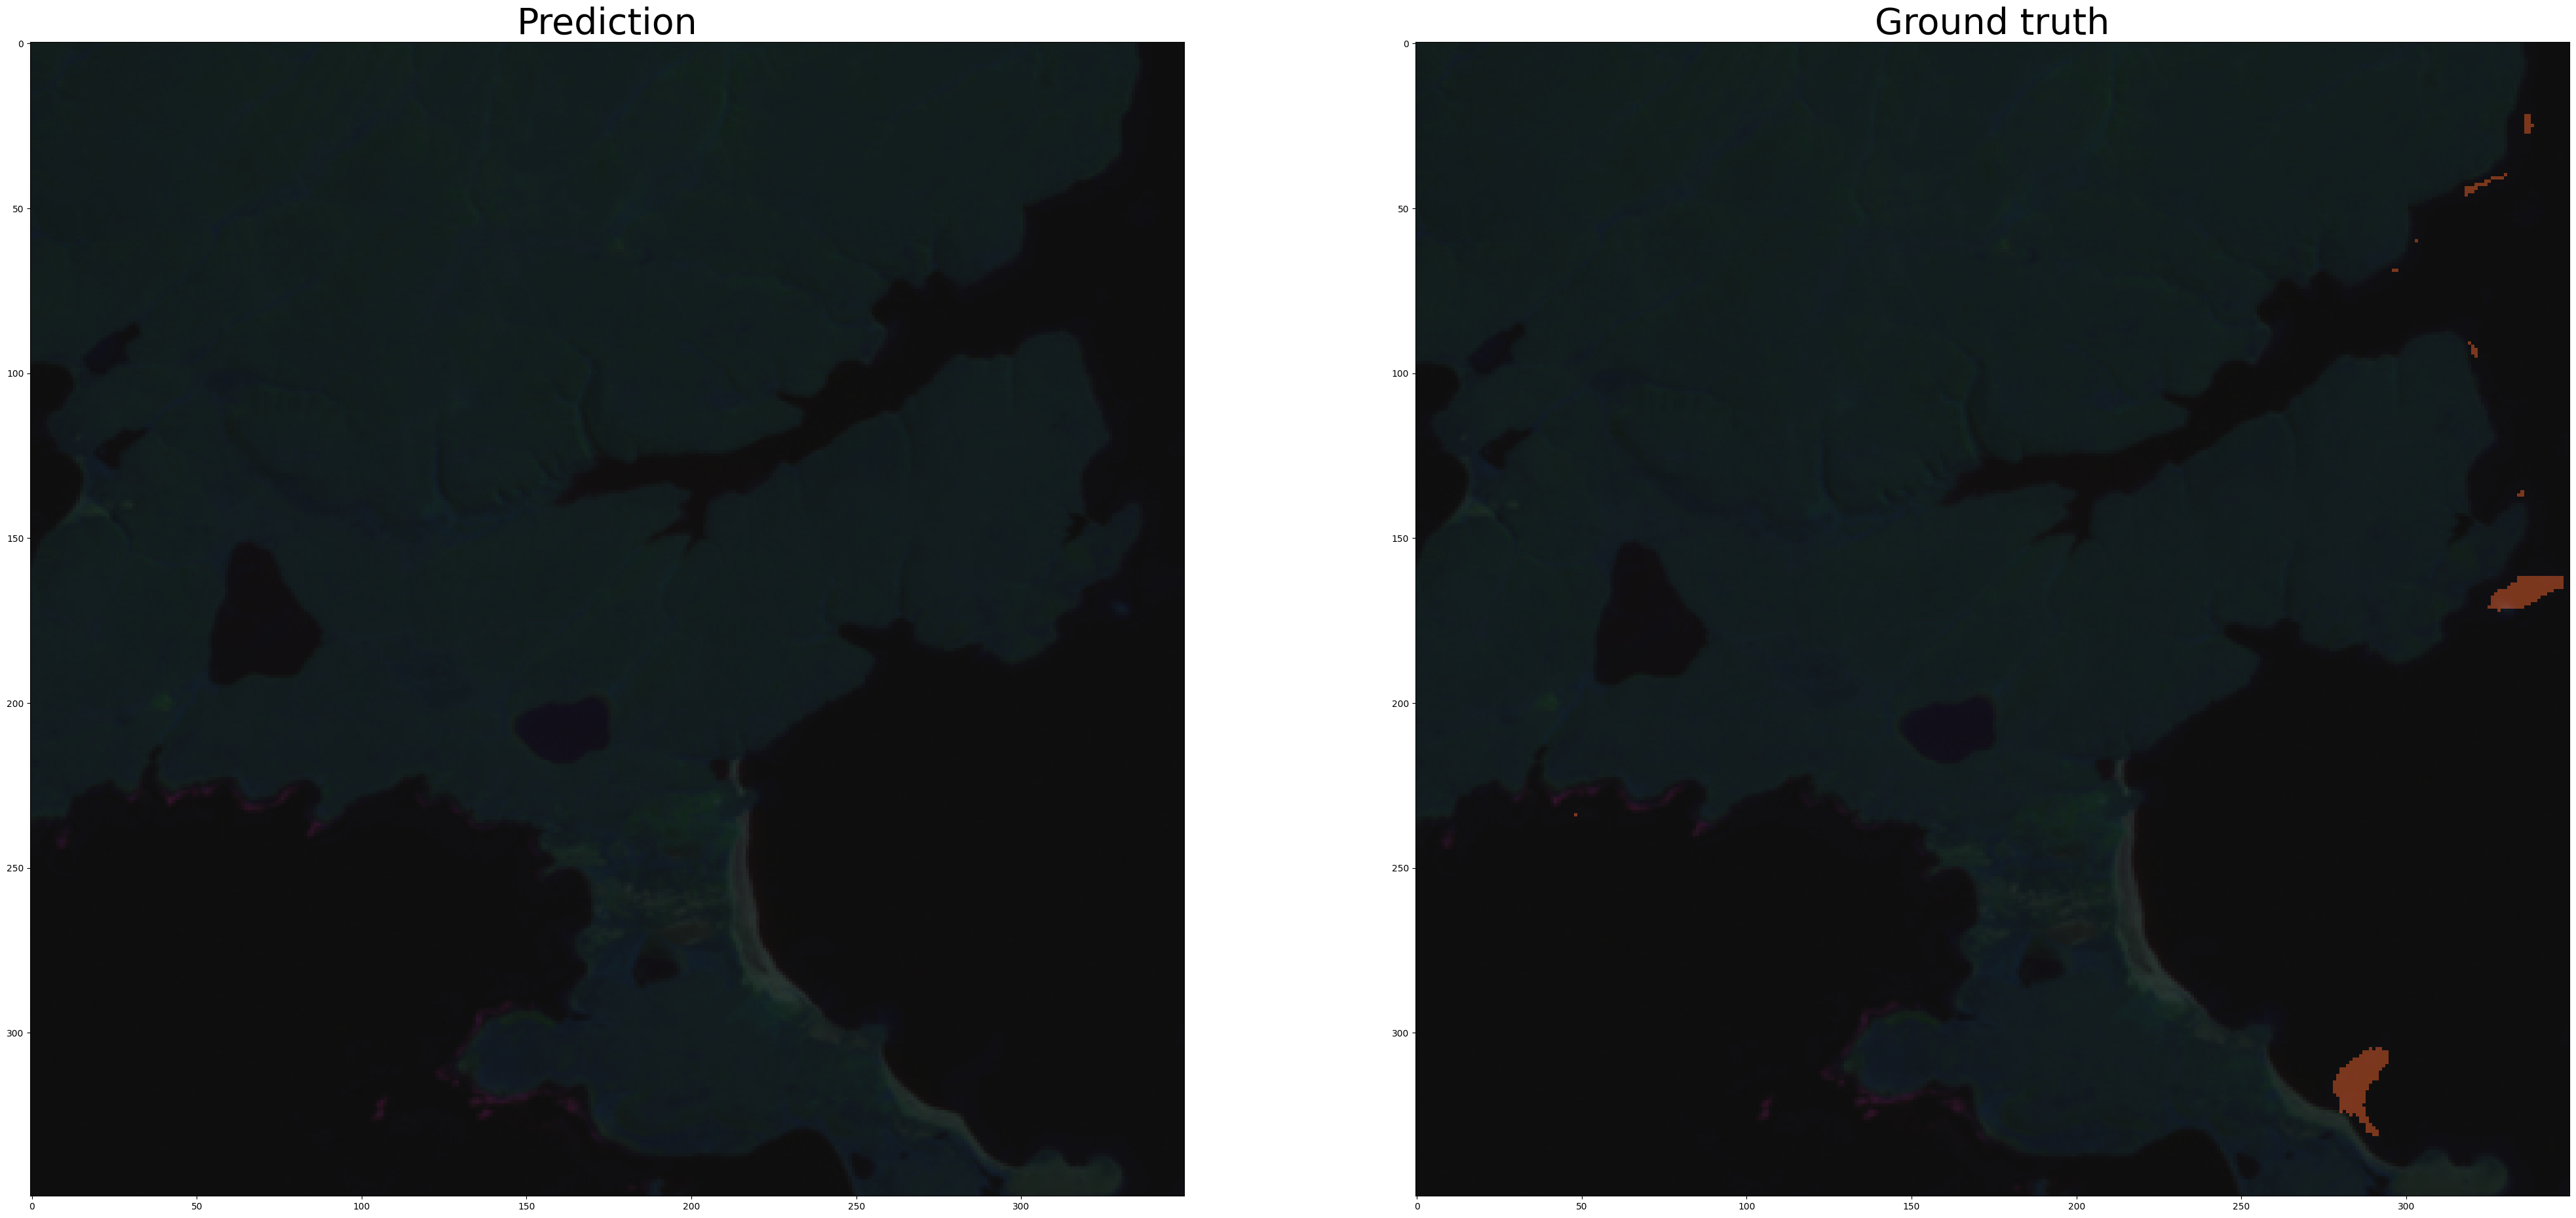

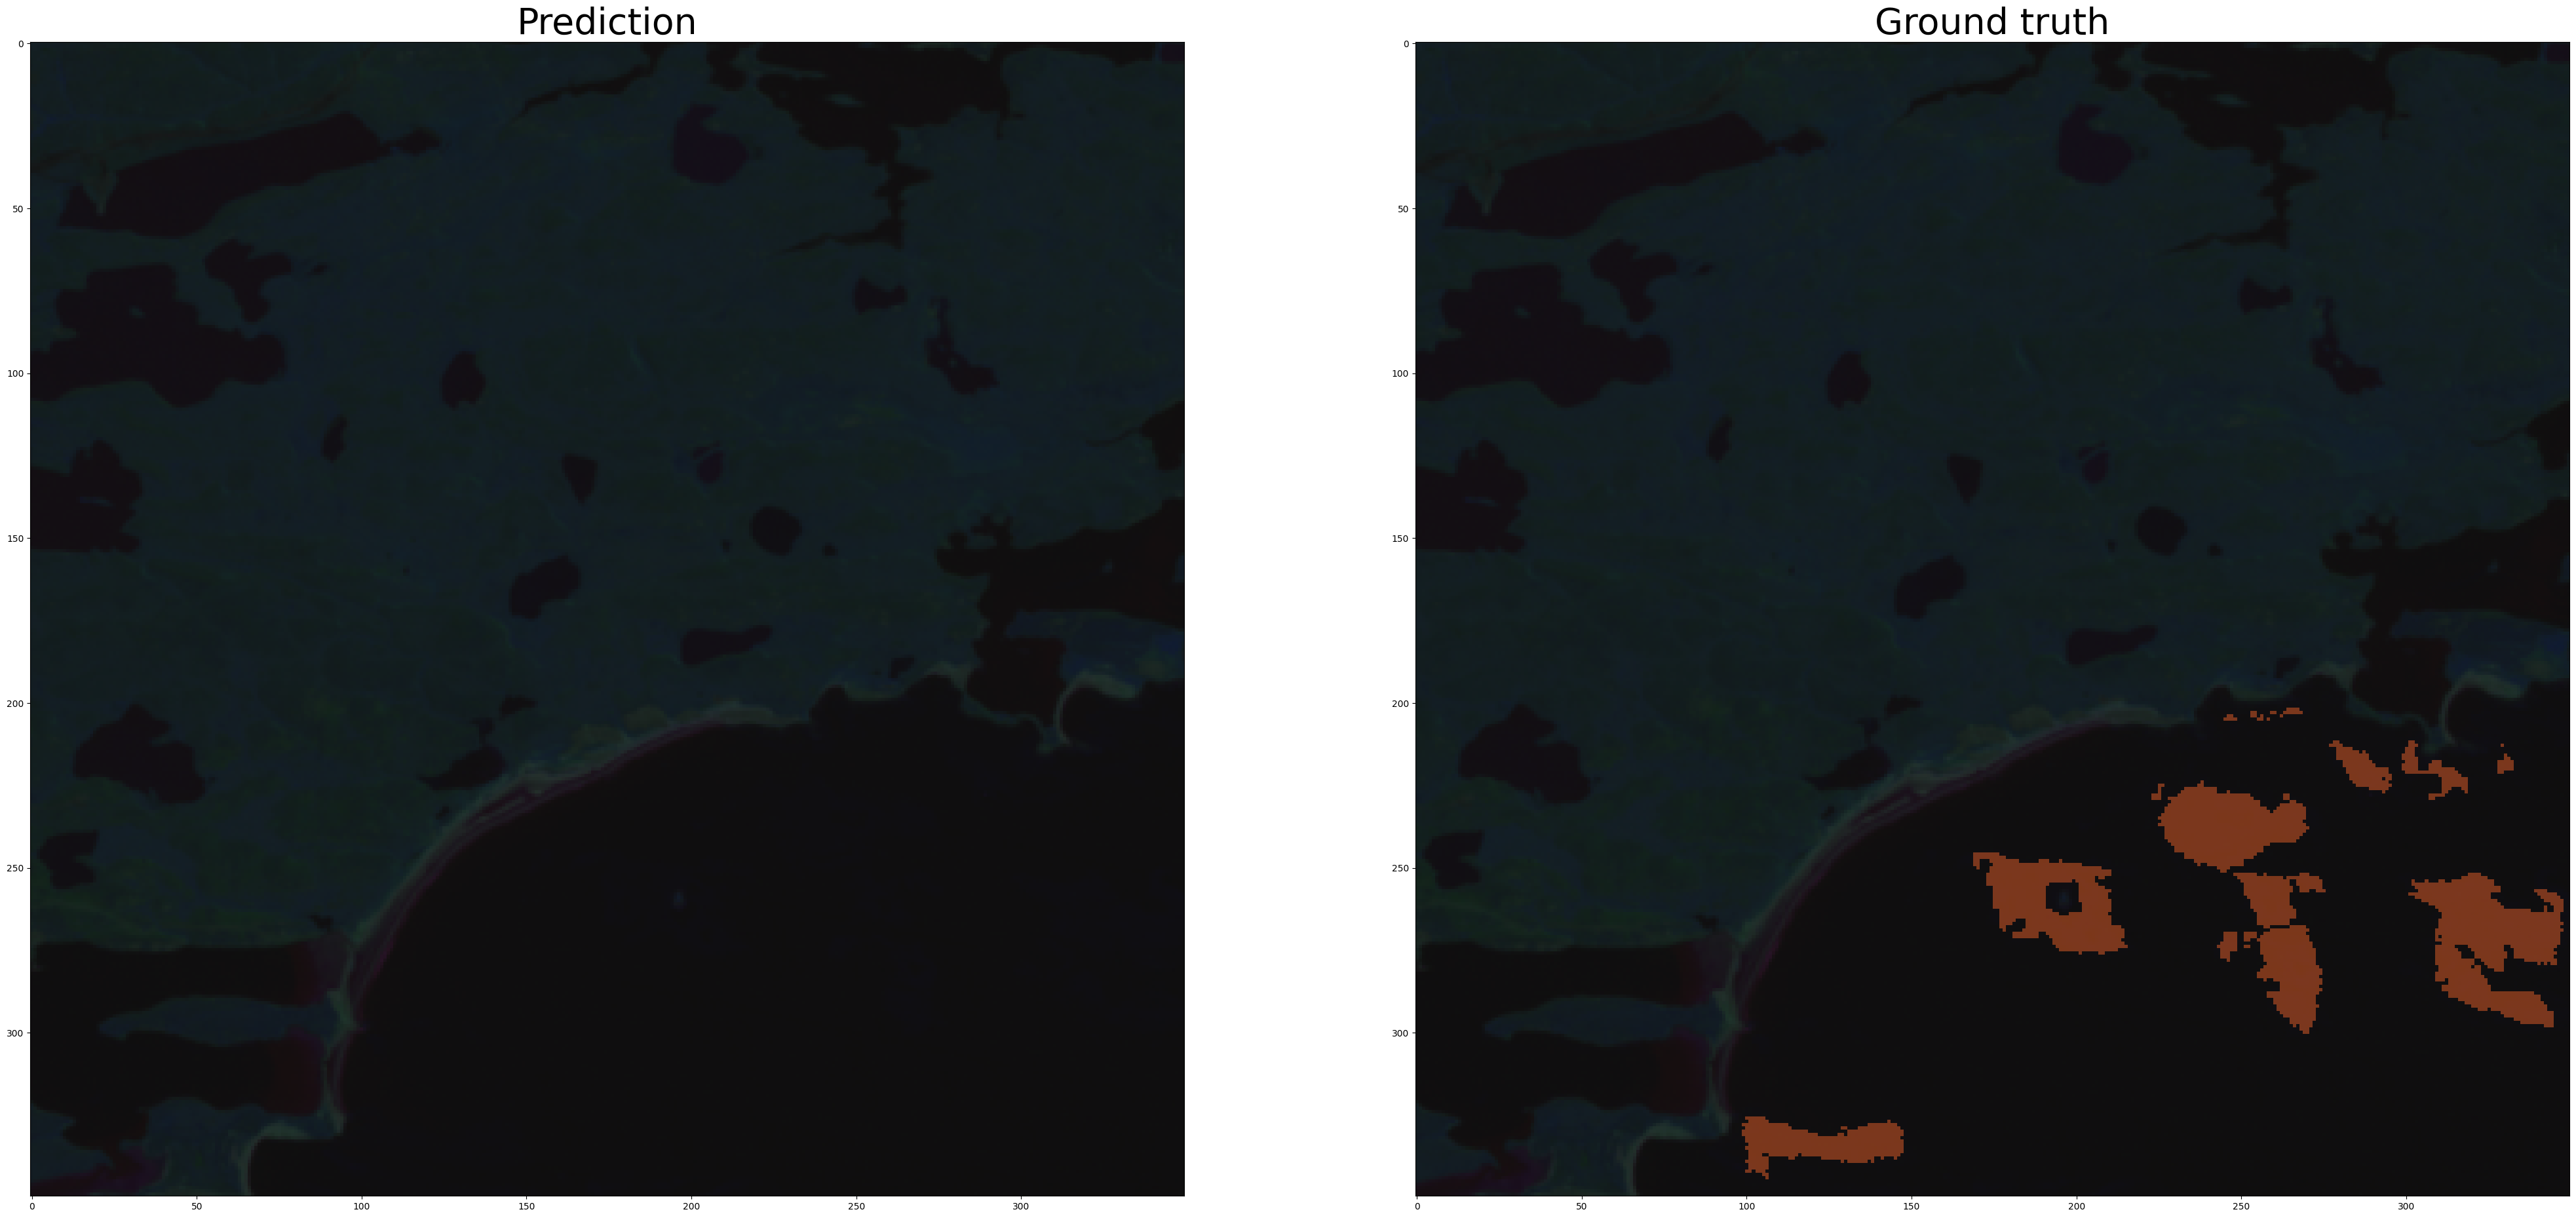

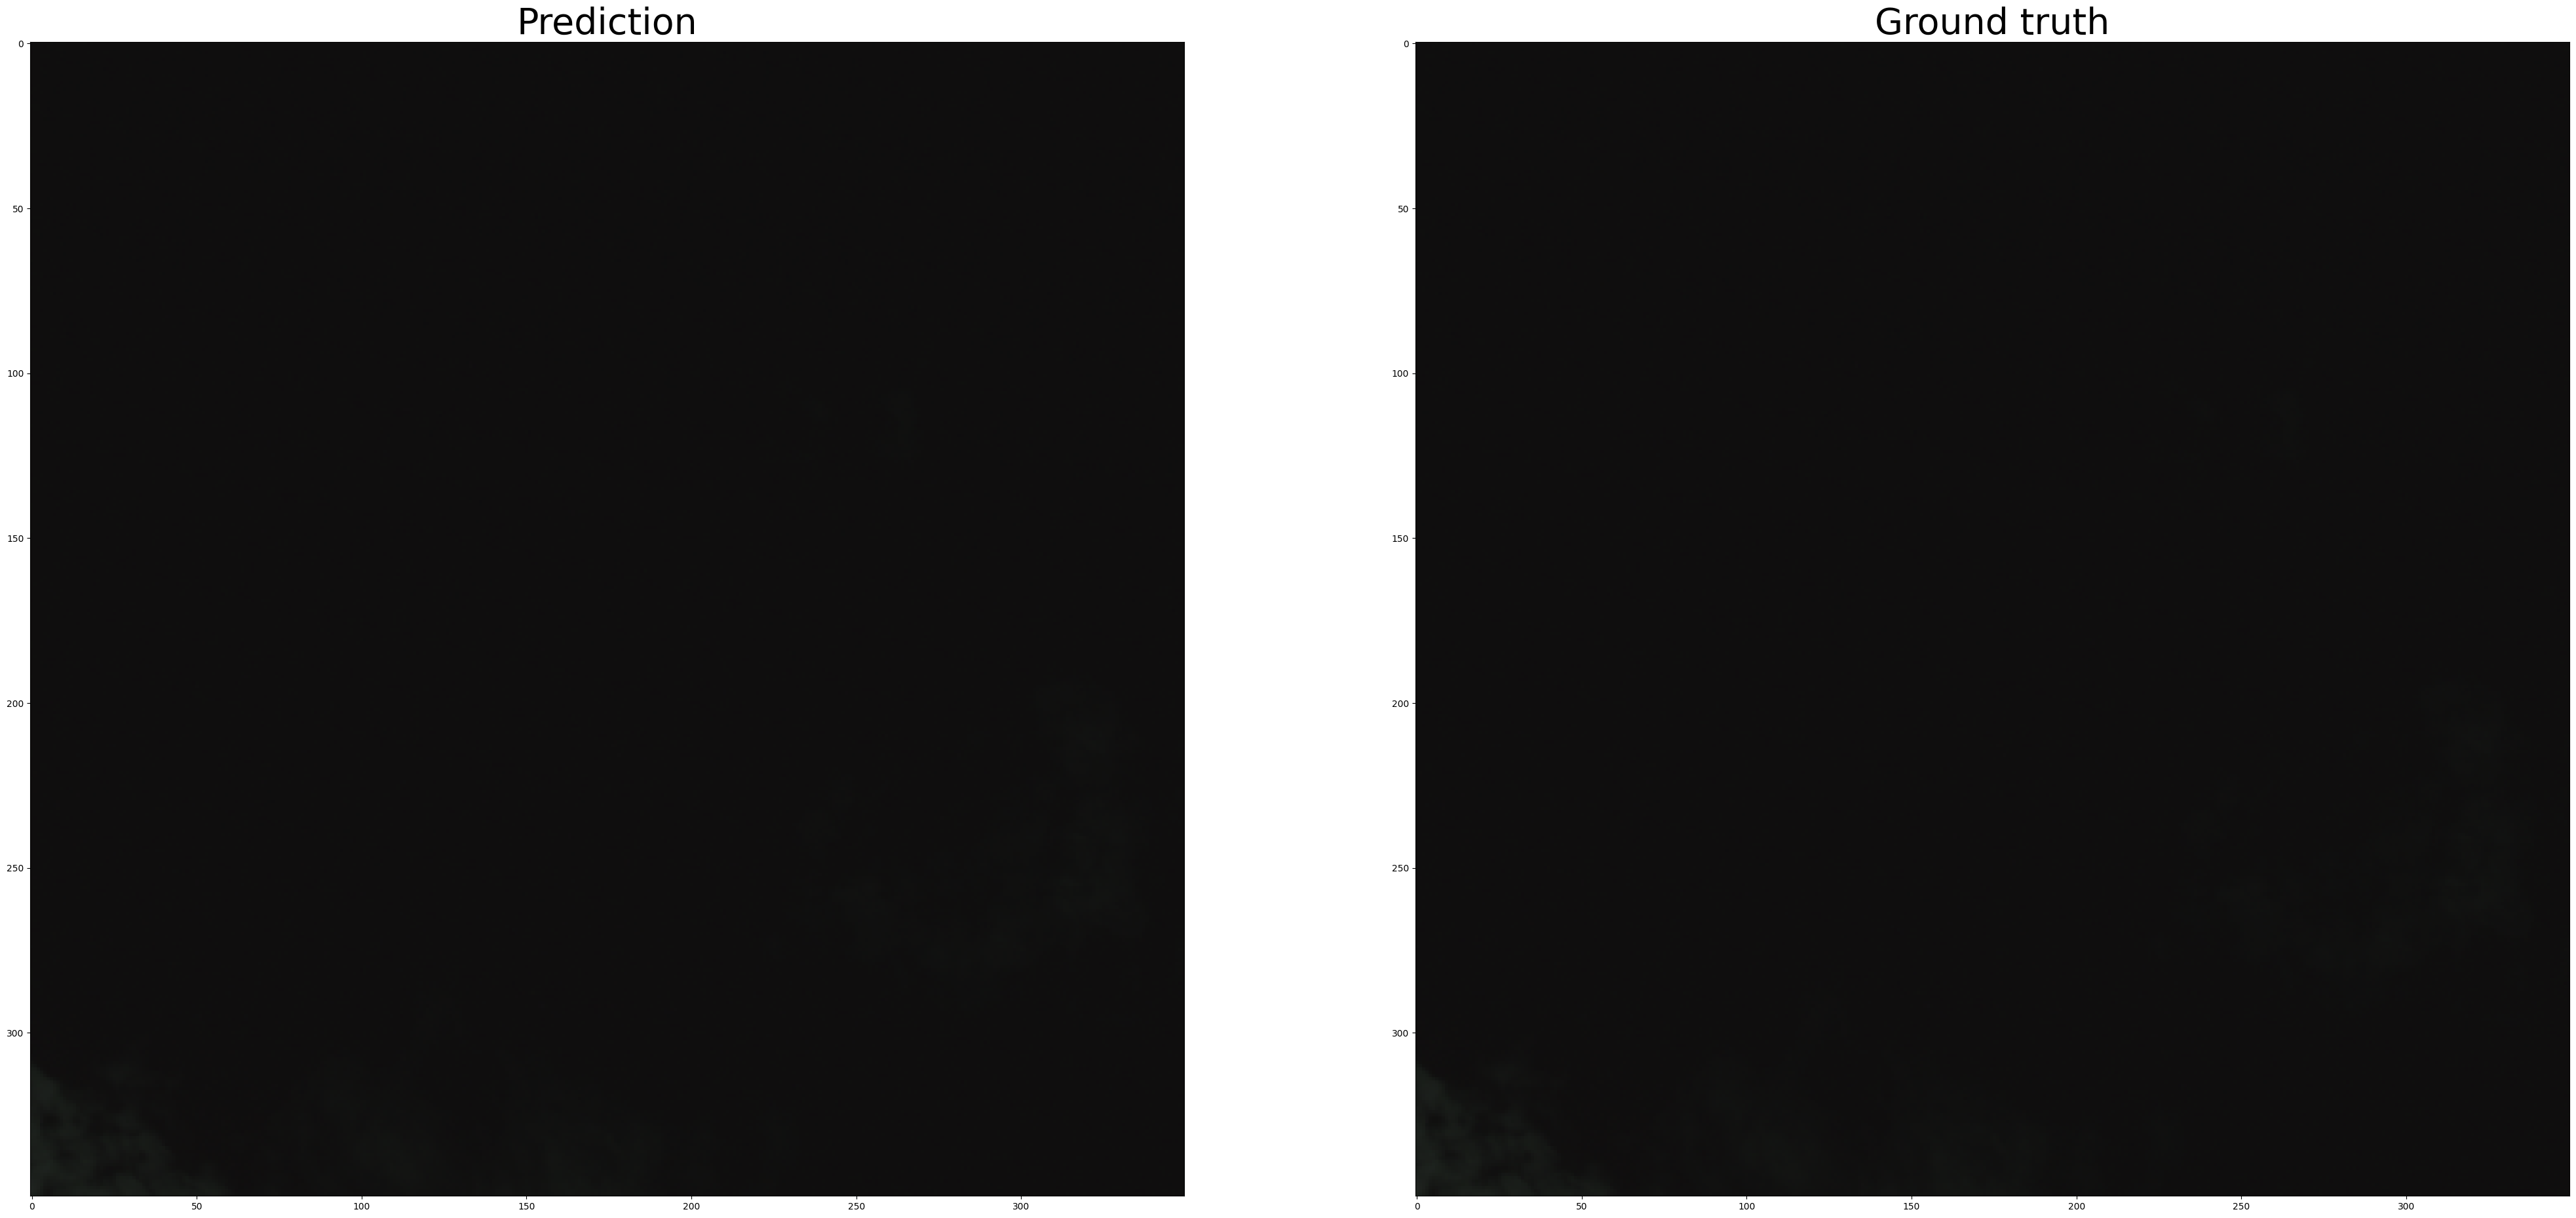

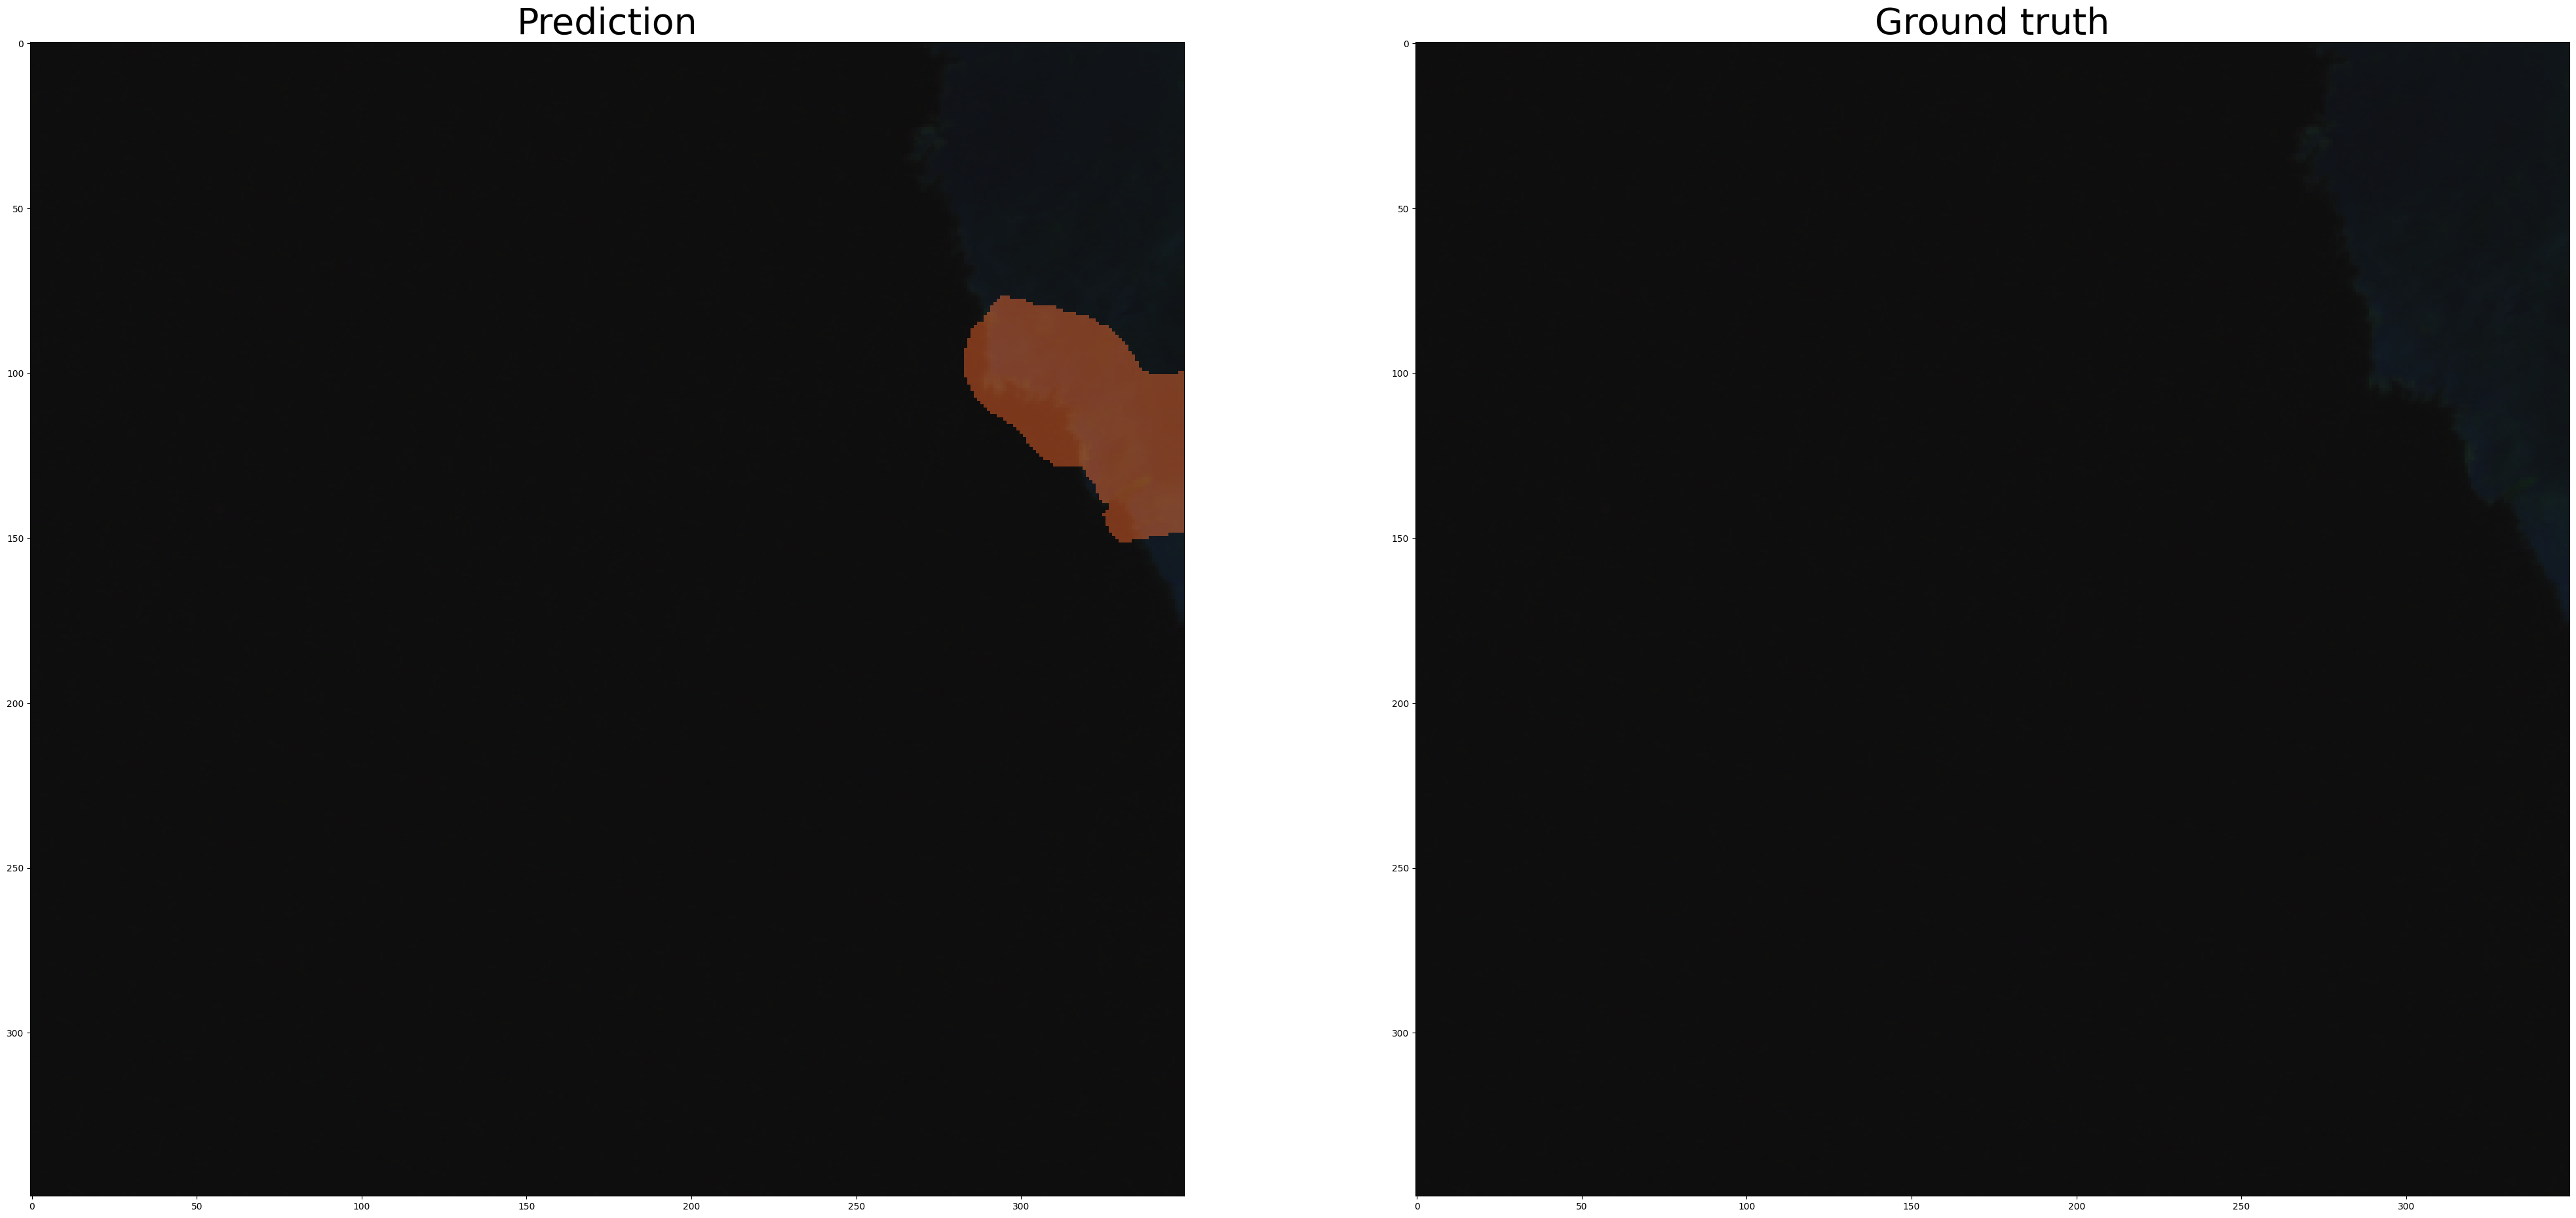

In [51]:
import matplotlib.pyplot as plt

for i in range(90,100):
    image = test_ds[i]['pixel_values']
    gt_seg = test_ds[i]['label']
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1], # (height, width)
        mode='bilinear',
        align_corners=False
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]

    pred_img = get_seg_overlay(image, pred_seg)
    
    gt_img = get_seg_overlay(image, np.array(gt_seg))

    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)

    axs[0].set_title("Prediction", {'fontsize': 40})
    axs[0].imshow(pred_img)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(gt_img)